### Required activity 25.3: Portfolio project on optimising a model for real-life data

This project aims to predict stock prices using Long Short-Term Memory (LSTM) networks. At the end of the project, we will use Optuna to find the optimal hyperparameters to minimize the loss function.

1. [Obtaining a Dataset](#Obtainingadataset)
2. [Exploratory Data Analysis](#ExploratoryDataAnalysis)
3. [ML techniques and data partition](#MLtechniquesanddatapartition)
4. [Optimize LSTM hyperparameters](#OptimizeLSTMhyperparameters)

#### Enhancement
1. [Simple Moving Average Strategy](#SimpleMovingAverages)
2. [Momentum Strategy](#MomentumStrategies)
3. [Mean Reversion Strategy](#MeanReversionStrategies)

In [2]:
#!pip install pandas_market_calendars
#!pip install yfinance
#!pip install torch

In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import seaborn as sb
import datetime
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta

now = datetime.now().date()
startdate = now - timedelta(days=365*6) # 10 years

<a id="Obtainingadataset"></a>

### Part 1. Obtaining a dataset

yfinance offers a threaded and Pythonic way to download market data from Yahoo!Ⓡ finance. 

1. https://github.com/ranaroussi/yfinance


This enable us to download day to day market data when market closes. Some other data that can be downloaded are..

1. dividends 
2. splits
3. capital gains
4. share count
5. income statement
6. quarterly income statement
7. quarterly balance sheet
8. quarterly cashflow
9. major share holders
10. news
11. and more...

Starting from the initial stage, we will be using just Tesla stock's closing price.

In [5]:
# 1. Fetch Historical Stock Prices
tsla = yf.Ticker("TSLA")
tsla = tsla.history(start=startdate)
tsla.head(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-24 00:00:00-04:00,21.379999,21.590000,21.293333,21.521334,54039000,0.0,0.0
2018-08-27 00:00:00-04:00,21.200001,21.496000,20.587334,21.284666,196189500,0.0,0.0
2018-08-28 00:00:00-04:00,21.227333,21.258667,20.746000,20.790667,114736500,0.0,0.0
2018-08-29 00:00:00-04:00,20.684668,20.790001,20.246000,20.334000,111711000,0.0,0.0
2018-08-30 00:00:00-04:00,20.150667,20.306667,19.848000,20.209999,108250500,0.0,0.0


In [6]:
tsla.index = tsla.index.strftime('%Y-%m-%d')
tsla.index = pd.to_datetime(tsla.index)
tsla

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-08-24,21.379999,21.590000,21.293333,21.521334,54039000,0.0,0.0
2018-08-27,21.200001,21.496000,20.587334,21.284666,196189500,0.0,0.0
2018-08-28,21.227333,21.258667,20.746000,20.790667,114736500,0.0,0.0
2018-08-29,20.684668,20.790001,20.246000,20.334000,111711000,0.0,0.0
2018-08-30,20.150667,20.306667,19.848000,20.209999,108250500,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-15,205.020004,215.880005,204.820007,214.139999,89848500,0.0,0.0
2024-08-16,211.149994,219.800003,210.800003,216.119995,88765100,0.0,0.0
2024-08-19,217.070007,222.979996,214.089996,222.720001,76435200,0.0,0.0


In [7]:
nasdaq = yf.Ticker("^IXIC")
sp500 = yf.Ticker("^GSPC")

nasdaq_price = nasdaq.history(start=startdate)
sp500_price = sp500.history(start=startdate)

nasdaq_price.index = nasdaq_price.index.strftime('%Y-%m-%d')
nasdaq_price.index = pd.to_datetime(nasdaq_price.index)

sp500_price.index = sp500_price.index.strftime('%Y-%m-%d')
sp500_price.index = pd.to_datetime(sp500_price.index)

<a id="SimpleMovingAverages"></a>
### Simple Moving Averages

Decades old strategy with origin in technical stock analysis world. The most popular moving average for long term investor are 50 days and 200 days, while shorter term investors looks at 10 days and 20 days
SMA1 : 10 days
SMA2 : 20 days

Long position: SMA1 is above SMA2
Short position: SMA2 is above SMA1

### Feature Engineer 1:
Create a column based on SMA. Long position == 1, Short position == -1

In [9]:
tsla_price = tsla
short_days = 50 
long_days = 200

tsla_price['SMA_1'] = tsla_price['Close'].rolling(short_days).mean()
tsla_price['SMA_2'] = tsla_price['Close'].rolling(long_days).mean()
tsla_price.shape

(1507, 9)

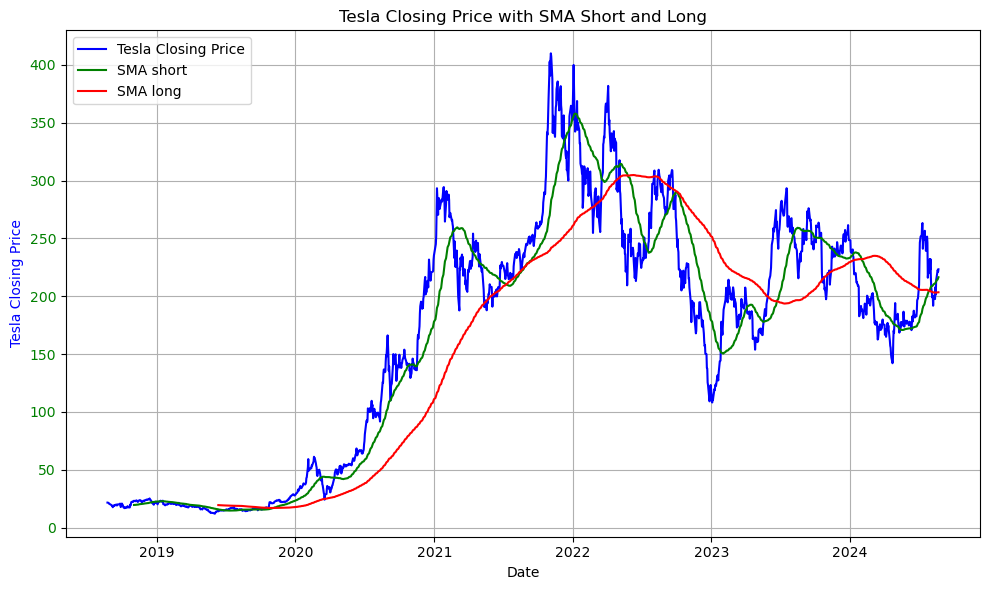

In [10]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tsla_price.index, tsla_price['Close'], label='Tesla Closing Price', color='b')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='b')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax1.plot(tsla_price.index, tsla_price['SMA_1'], label='SMA short', color='g')
ax1.plot(tsla_price.index, tsla_price['SMA_2'], label='SMA long', color='r')

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')
plt.title('Tesla Closing Price with SMA Short and Long')
fig.tight_layout()
plt.show()


In [11]:
# Feature engineering 1: SMA_position

tsla_price['SMA_position'] = np.where(tsla_price['SMA_1'] > tsla_price['SMA_2'], 1, -1)

tsla_price.dropna(inplace = True)
tsla_price.shape

(1308, 10)

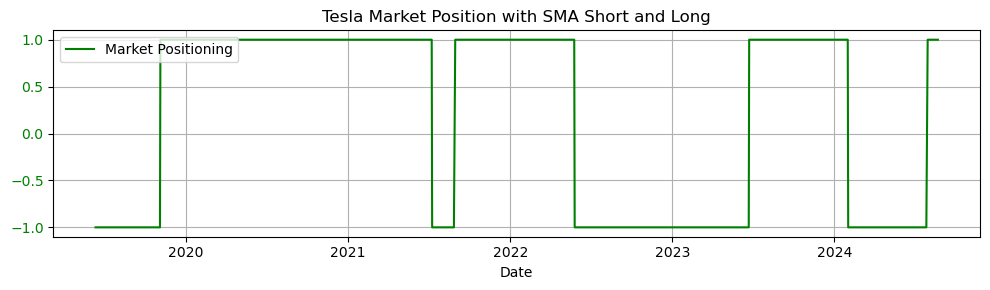

In [12]:
fig, ax1 = plt.subplots(figsize=(10, 3))

ax1.plot(tsla_price.index, tsla_price['SMA_position'], label='Market Positioning', color='g')
ax1.set_xlabel('Date')
ax1.ylim=[-1.1,1.1]
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')
plt.title('Tesla Market Position with SMA Short and Long')
fig.tight_layout()
plt.show()


Natural logarithms are preferred in finance primarily due to their mathematical properties, which align well with the needs of financial modeling, especially when dealing with compounding, normality assumptions, and the additivity of returns.

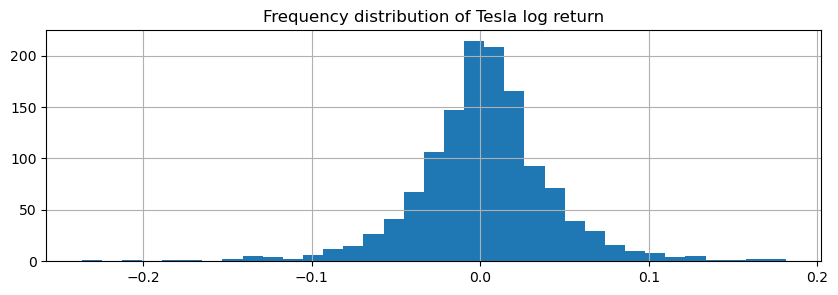

In [14]:
tsla_price['SMA_return'] = np.log(tsla_price['Close'] / tsla_price['Close'].shift(1))
tsla_price['SMA_return'].hist(bins=35, figsize=(10,3))
plt.title('Frequency distribution of Tesla log return')
plt.show()

In [15]:
# Fees not included
tsla_price['SMA_strat'] = tsla_price['SMA_position'].shift(1) * tsla_price['SMA_return']
print(tsla_price[['SMA_return', 'SMA_strat']].sum())

# Inverse of the natural logarithm) to each sum. 
# The exponential function converts the cumulative log return back into a cumulative simple return.
print(f"\nGross performance:\n{tsla_price[['SMA_return', 'SMA_strat']].sum().apply(np.exp)}")

SMA_return    2.772854
SMA_strat     1.146993
dtype: float64

Gross performance:
SMA_return    16.004253
SMA_strat      3.148710
dtype: float64


In [16]:
# Annualized mean return & standard deviation
print(f"Annualized mean return & standard deviation for SMA {short_days} & {long_days} are:")
print(np.exp(tsla_price[['SMA_return', 'SMA_strat']].mean() * 252) - 1)
print()
print((tsla_price[['SMA_return', 'SMA_strat']].apply(np.exp) - 1).std() * 252 ** 0.5)

Annualized mean return & standard deviation for SMA 50 & 200 are:
SMA_return    0.706814
SMA_strat     0.247510
dtype: float64

SMA_return    0.650032
SMA_strat     0.651031
dtype: float64


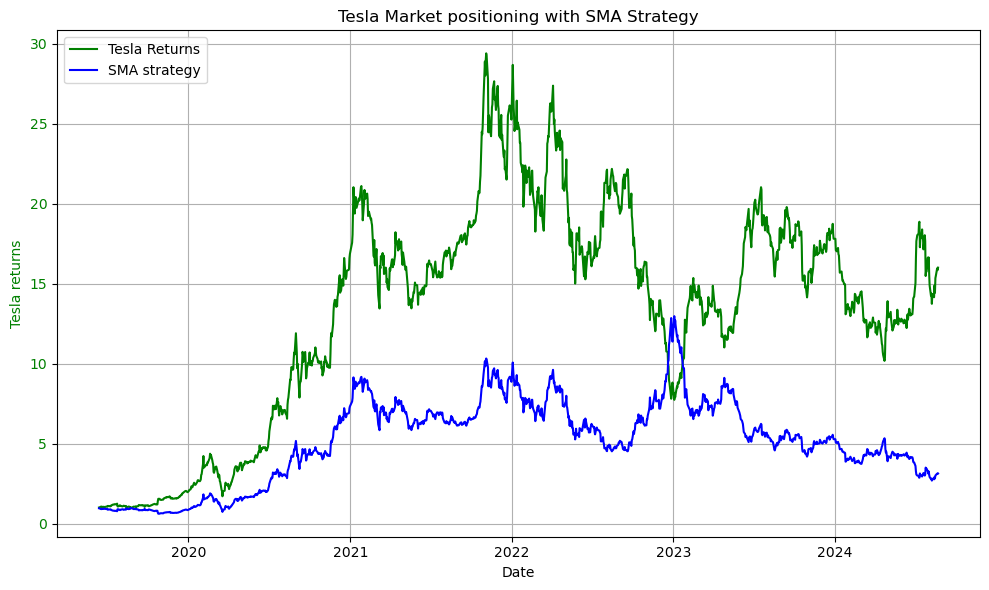

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tsla_price.index, tsla_price['SMA_return'].cumsum().apply(np.exp), label='Tesla Returns', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla returns', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax1.plot(tsla_price.index, tsla_price['SMA_strat'].cumsum().apply(np.exp), label='SMA strategy', color='b')

lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines, labels, loc='upper left')
plt.title('Tesla Market positioning with SMA Strategy')
fig.tight_layout()
plt.show()

SMA strategy doesn't perform better than staying in market with SMA of 50 / 200 days.

#### Risk statistics in trading strategy
1. Maximum drawdown
2. Longest drawdown period

<Axes: xlabel='Date'>

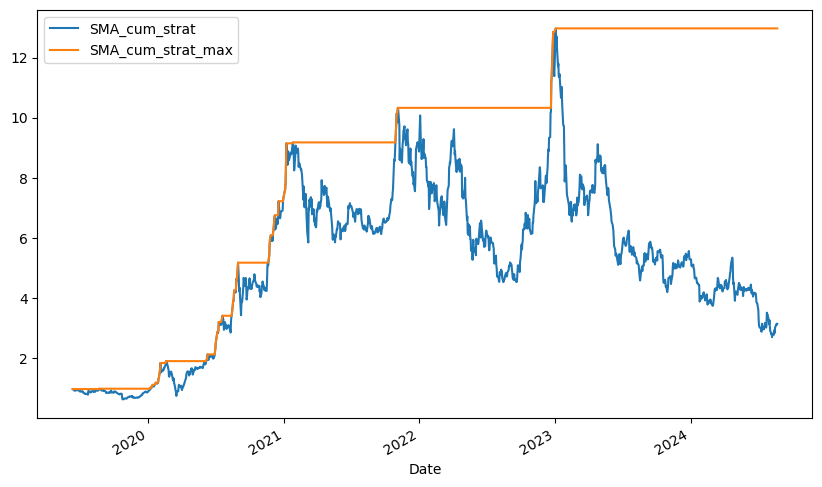

In [19]:
tsla_price['SMA_cum_strat'] = tsla_price['SMA_strat'].cumsum().apply(np.exp)
tsla_price['SMA_cum_strat_max'] = tsla_price['SMA_cum_strat'].cummax()
tsla_price[['SMA_cum_strat','SMA_cum_strat_max']].dropna().plot(figsize=(10,6))

In [20]:
drawdown = tsla_price['SMA_cum_strat_max'] - tsla_price['SMA_cum_strat']

temp = drawdown[drawdown == 0]
periods = (temp.index[1:].to_pydatetime() - temp.index[:-1].to_pydatetime())
print(f"The maximun drawdown is {drawdown.max():.2f}, with a period of {periods.max()}\n")

The maximun drawdown is 10.27, with a period of 413 days, 0:00:00



In [21]:
#tsla_price.info()

In [22]:
#tsla_price = tsla_price.dropna()

In [23]:
#tsla_price.info()

In [24]:
import SMAVectorBacktester as SMA

smabt = SMA.SMAVectorBacktester(
    symbol='Close',  
    SMA1=short_days,
    SMA2=long_days,
    start=tsla_price.index[0].date(),  # Start date from your DataFrame
    end=tsla_price.index[-1].date(),   # End date from your DataFrame
    data=tsla_price                    # Pass the entire DataFrame
)

print(smabt.run_strategy())

(2.87, -3.47)


In [25]:
%%time
opt , b = smabt.optimize_parameters((10,50,5), (20,200,10)) # Min & Max of both long and short term investors
print(f"Optimized parameters for SMA are {opt[0]} and {opt[1]}")

Optimized parameters for SMA are 10.0 and 20.0
CPU times: total: 344 ms
Wall time: 571 ms


In [26]:
smabt = SMA.SMAVectorBacktester(
    symbol = 'Close',  
    SMA1 = int(opt[0]),
    SMA2 = int(opt[1]),
    start = tsla_price.index[0].date(),  # Start date from your DataFrame
    end = tsla_price.index[-1].date(),   # End date from your DataFrame
    data = tsla_price                    # Pass the entire DataFrame
)
print(smabt.run_strategy())

(176.01, 161.99)


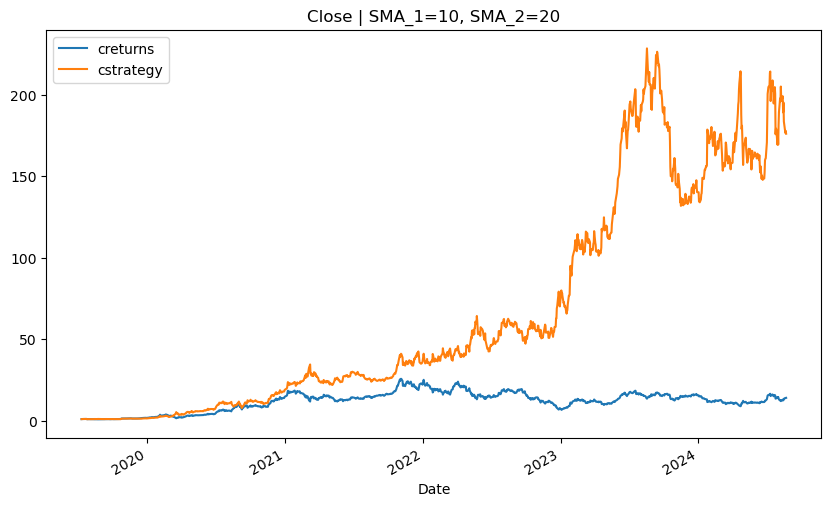

In [27]:
# Applying the optimized parameter from smabt
smabt.plot_results()

In [28]:
# Annualized mean return 
tsla_price['SMA_strat'] = tsla_price['SMA_position'].shift(1) * tsla_price['SMA_return']
np.exp(tsla_price[['SMA_return', 'SMA_strat']].mean() * 252) - 1

SMA_return    0.706814
SMA_strat     0.247510
dtype: float64

Optimized parameters for SMA has outperformed the base intrument. The optimized strategy yield an absolute return of 140.88 for short SMA = 10 and long SMA 20

<a id="Momentum Strategies"></a>
### Momentum Strategies

1. Cross Sectional momentum strategies
   
    1.1 Comparing the performance of a group of assets relative to each other over a specific time period. The strategy typically involves buying the assets that have performed the best (relative winners) and selling/shorting the assets that have performed the worst (relative losers) over the same period.
2. Time Series momentum strategies
   
    2.1 Evaluating the performance of a single asset over time. The strategy typically involves buying the asset if it has shown positive returns (momentum) over a past period and selling/shorting it if it has shown negative returns over that same period.


In [31]:
# similar to column 'SMA_return'
tsla_price['momentum_return'] = np.log(tsla_price['Close'] / tsla_price['Close'].shift(1)) 

tsla_price['momentum_position'] = np.sign(tsla_price['momentum_return'])

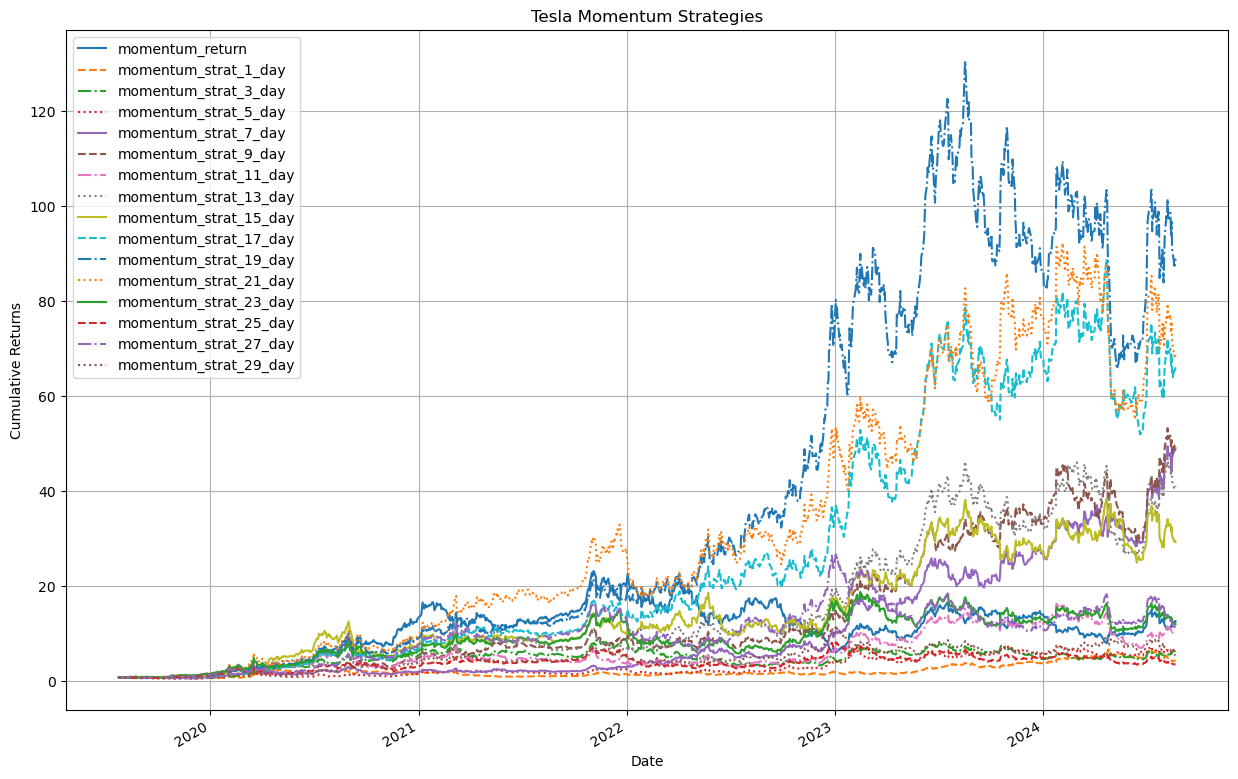

In [32]:
to_plot = pd.DataFrame(index=tsla_price.index)
to_plot['momentum_return'] = tsla_price['momentum_return']

# Loop through a range of look-back periods from 1 day to 29 days
for look_back in range(1, 30, 2):
    momentum_position = np.sign(tsla_price['momentum_return'].rolling(look_back).mean())
    momentum_strategy = momentum_position.shift(1) * tsla_price['momentum_return']
    to_plot[f'momentum_strat_{look_back}_day'] = momentum_strategy

cumulative_returns = to_plot.dropna().cumsum().apply(np.exp)

styles = ['-', '--', '-.', ':'] * (len(to_plot.columns) // 4 + 1)
cumulative_returns.plot(
    title='Tesla Momentum Strategies', 
    figsize=(15, 10), 
    style=styles[:len(to_plot.columns)]
)
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [33]:
# Find the strategy with the highest ending value
final_values = cumulative_returns.iloc[-1]  # Get the last row with final cumulative values
best_strategy = final_values.idxmax()  # Find the column with the highest value
best_value = final_values.max()  # Get the highest value

print(f"The momentum strategy '{best_strategy}' has the highest ending value of {best_value:.2f}.")

The momentum strategy 'momentum_strat_19_day' has the highest ending value of 88.90.


In [34]:
tsla_price['momentum_strat'] = to_plot[best_strategy]

(895340.89, 755166.36)


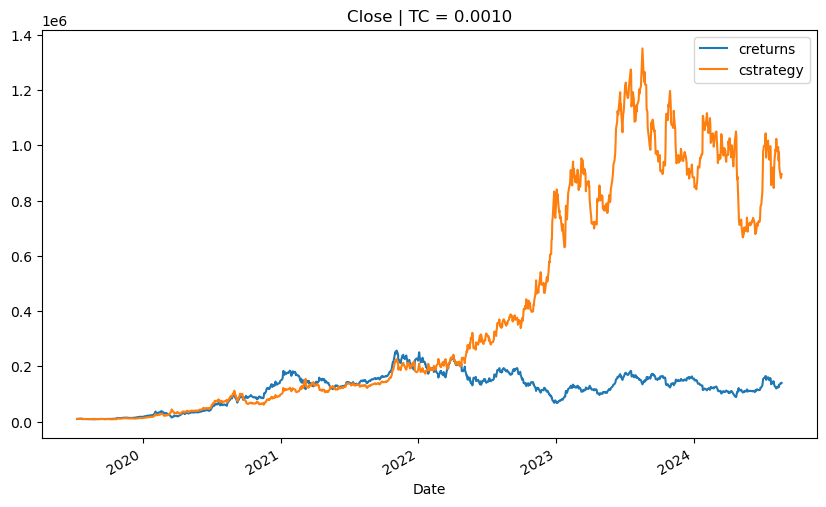

In [35]:
import MomVectorBacktester as Mom

#0.1% cost per trade
mombt = Mom.MomVectorBacktester('Close', tsla_price, tsla_price.index[0].date(), tsla_price.index[-1].date(), 10000, 0.001) 

print(mombt.run_strategy(momentum=19))
mombt.plot_results()

<a id="MeanReversionStrategies"></a>
### Mean Reversion Strategies

Tendency of asset price to return to a trend path.

If a financial instrument has significantly deviated from its historical trend, a mean reversion strategy posits that it will eventually return to its mean or average trend. Unlike momentum strategies, which bet on the continuation of a current trend (positive correlation), mean reversion strategies bet on a reversal or correction (negative correlation), expecting the instrument to move back toward its historical average

In [37]:
# Using SMA for proximation of trend path
SMA = 43
threshold = 50

tsla_price['mean_rev_SMA'] = tsla_price['Close'].rolling(SMA).mean() 

tsla_price['mean_rev_distance'] = tsla_price['Close'] - tsla_price['mean_rev_SMA']

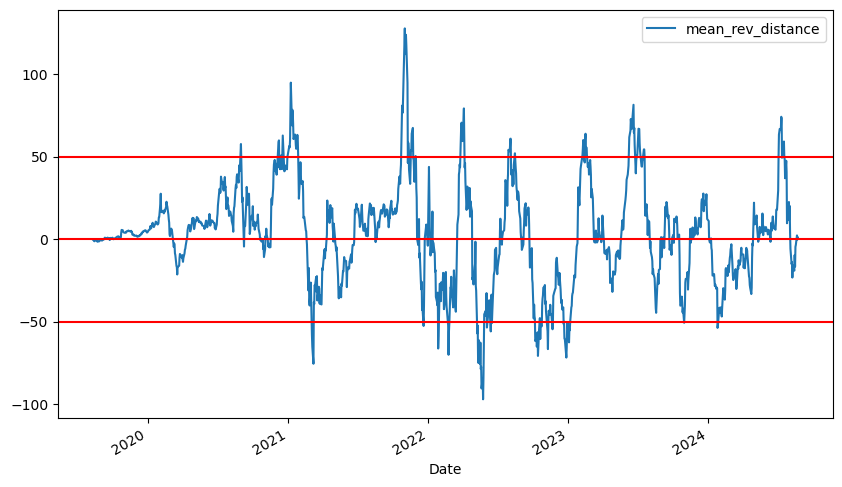

In [38]:
tsla_price['mean_rev_distance'].dropna().plot(figsize = (10,6), legend=True)
plt.axhline(threshold, color = 'r')
plt.axhline(-threshold, color = 'r')

plt.axhline(0, color = 'r')

<Axes: xlabel='Date'>

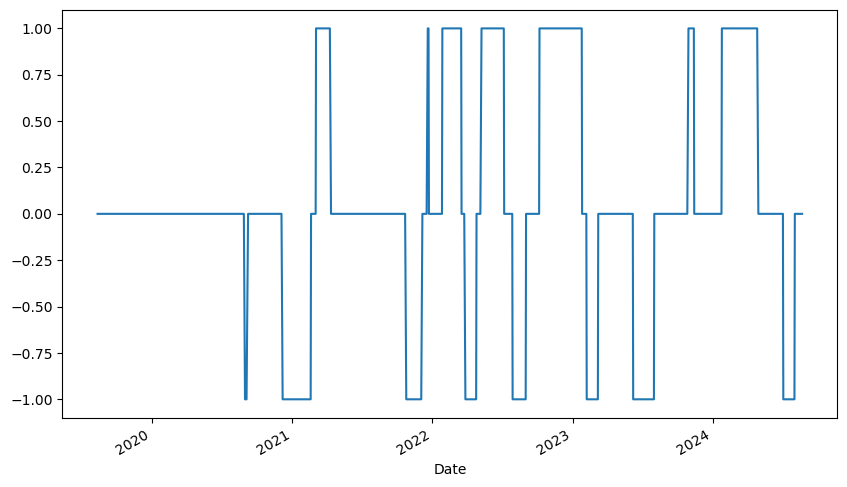

In [39]:
# Initialize the position column with NaN
tsla_price['mean_rev_position'] = np.nan

# Bet on short (-1) when price is above the threshold
tsla_price.loc[tsla_price['mean_rev_distance'] > threshold, 'mean_rev_position'] = -1

# Bet on long (1) when price is below the threshold
tsla_price.loc[tsla_price['mean_rev_distance'] < -threshold, 'mean_rev_position'] = 1

# Set position to 0 when crossing the mean (changing direction)
tsla_price.loc[tsla_price['mean_rev_distance'] * tsla_price['mean_rev_distance'].shift(1) < 0, 'mean_rev_position'] = 0

# Forward fill the positions to maintain the position until the next signal
tsla_price['mean_rev_position'] = tsla_price['mean_rev_position'].ffill().fillna(0)

tsla_price['mean_rev_position'].iloc[SMA:].plot(ylim = [-1.1, 1.1], figsize = (10,6))


<Axes: xlabel='Date'>

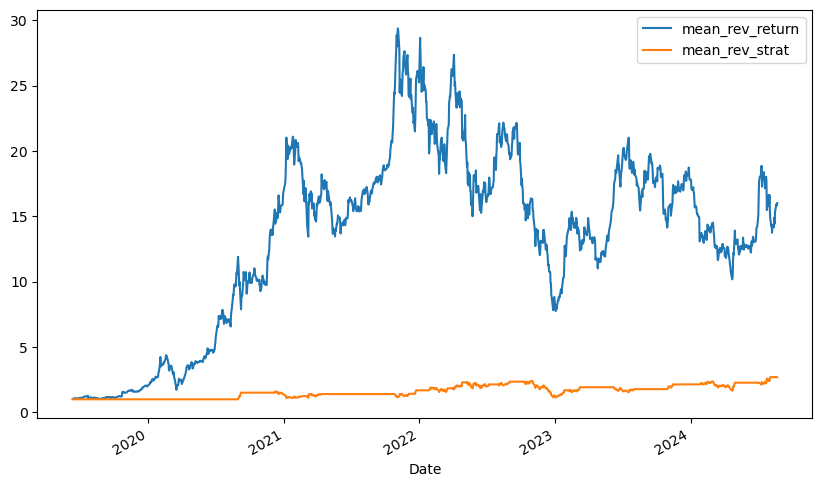

In [40]:
tsla_price['mean_rev_return'] = np.log(tsla_price['Close'] / tsla_price['Close'].shift(1)) 

tsla_price['mean_rev_strat'] = tsla_price['mean_rev_position'].shift(1) * tsla_price['mean_rev_return']

tsla_price[['mean_rev_return', 'mean_rev_strat']].dropna().cumsum().apply(np.exp).plot(figsize = (10,6))

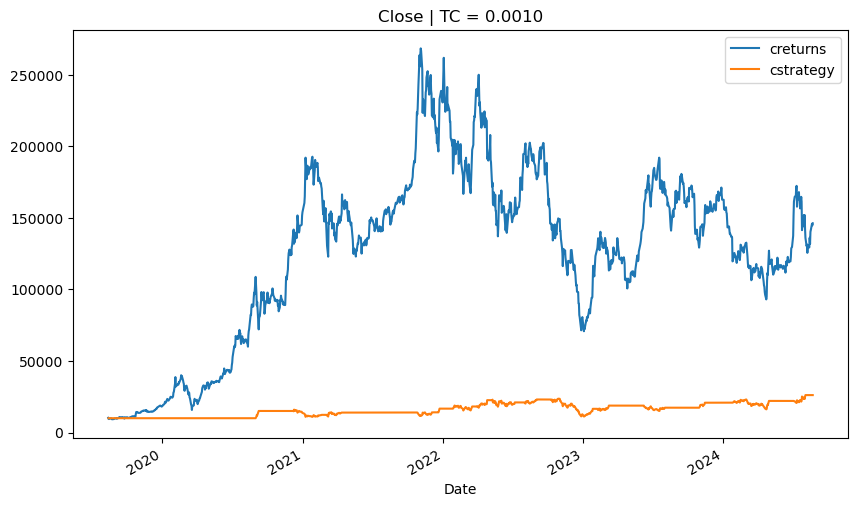

In [41]:
import MRVectorBacktester as MR

mrbt = MR.MRVectorBacktester('Close', tsla_price, tsla_price.index[0].date(), tsla_price.index[-1].date(), 10000, 0.001)

mrbt.run_strategy(SMA= SMA, threshold = threshold)

mrbt.plot_results()

The Mean Reversion strategy underperformed compared to simply staying in the market. Stocks like Tesla, often classified as growth stocks, didn't demonstrate mean-reverting behavior because their valuations are driven by long-term growth prospects and innovations such as Full-Self Driving and the Optimus bot. Additionally, the high volatility typical of such growth stocks further diminishes the suitability of a Mean Reversion approach.


### Indices 

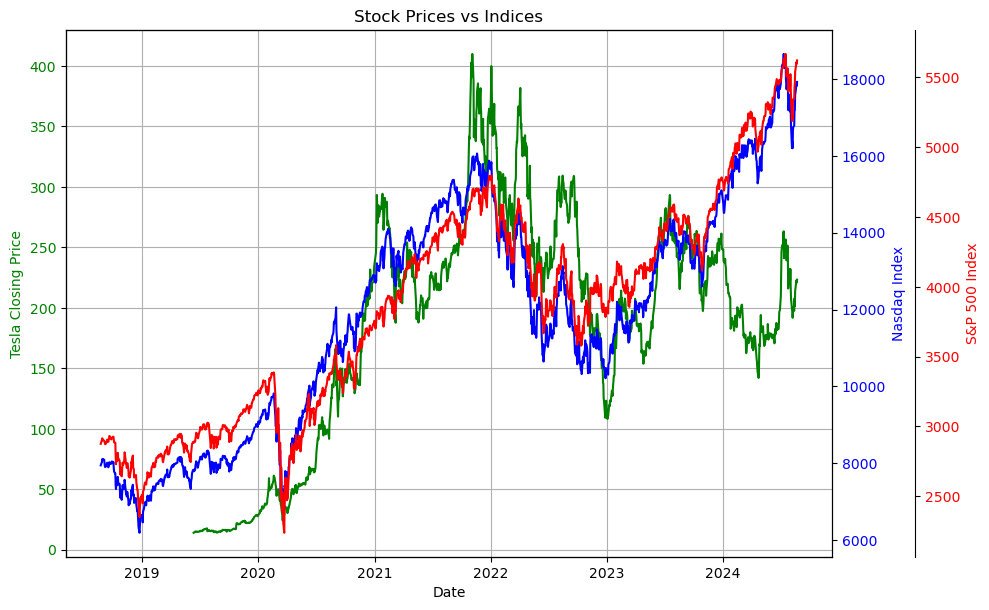

In [44]:
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.plot(tsla_price['Close'], label='Tesla Closing Price', color='g')
ax1.set_xlabel('Date')
ax1.set_ylabel('Tesla Closing Price', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(nasdaq_price['Close'], label='Nasdaq', color='b')
ax2.set_ylabel('Nasdaq Index', color='b')
ax2.tick_params(axis='y', labelcolor='b')

ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))
ax3.plot(sp500_price['Close'], label='S&P 500', color='r')
ax3.set_ylabel('S&P 500 Index', color='r')
ax3.tick_params(axis='y', labelcolor='r')

fig.tight_layout()
plt.title('Stock Prices vs Indices')
plt.show()

We can see the relationship between this tech stock and the major indices like the S&P 500 and NASDAQ. It's worth noting that TSLA was initially added to the NASDAQ-100 in June 2010 and later added to the S&P 500 on December 21, 2020.

From the plot, the trend was observed to break downward starting in 2023. Could this indicate that a pullback towards a new high coming? We note that Correlation Doesn't Mean Causation.

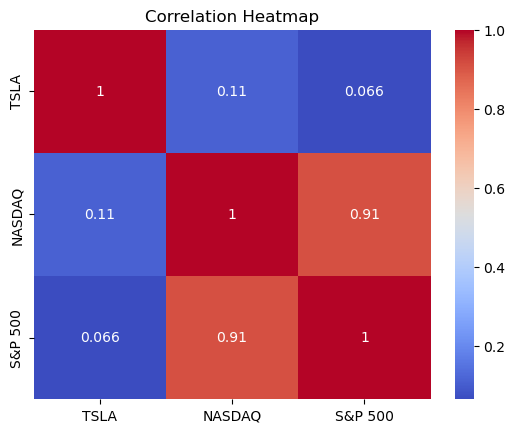

In [46]:
data = pd.DataFrame({
    'TSLA': tsla_price['Close'],
    'NASDAQ': nasdaq_price['Close'],
    'S&P 500': sp500_price['Close']
})

filtered_data = data.loc['2020-12-21':]

correlation = filtered_data.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap")
plt.show()

Another popular index that quantifies investor sentiment is the CBOE Volatility Index (VIX). It measures the market's expectation of near-term price changes for the S&P 500 index. Investors use options to hedge against potential market downturns, which can drive up the VIX price. Consequently, nervous investors tend to push the VIX higher.

Therefore, the VIX typically increases when stock prices fall and decreases when stock prices rise.

We choose the VIX over the VXN (which tracks the Nasdaq 100) because the VIX represents a broader market rather than focusing solely on the tech industry.

In [48]:
volatility_index = yf.Ticker("^VIX")

vix_price = volatility_index.history(start=tsla_price.index[0].date())

vix_price.index = vix_price.index.strftime('%Y-%m-%d')
vix_price.index = pd.to_datetime(vix_price.index)

vix_price.tail(5)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2024-08-15,16.27,16.68,14.77,15.23,0,0.0,0.0
2024-08-16,15.29,15.76,14.65,14.80,0,0.0,0.0
2024-08-19,15.94,16.07,14.46,14.65,0,0.0,0.0
2024-08-20,14.89,15.93,14.78,15.88,0,0.0,0.0
2024-08-21,16.25,17.17,15.92,16.27,0,0.0,0.0


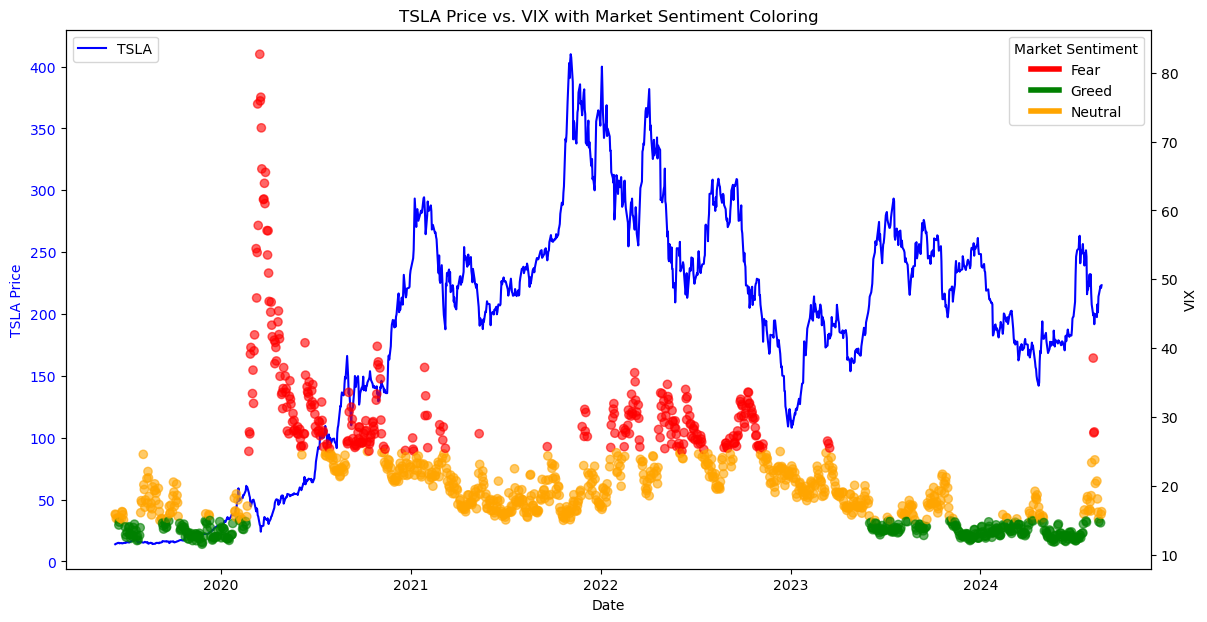

In [49]:
# Define thresholds for market sentiment based on VIX values
def get_vix_color(value):
    if value > 25:
        return 'red'    # Fear
    elif value < 15:
        return 'green'  # Greed
    else:
        return 'orange' # Neutral

# Create a new column in vix_price DataFrame for color
vix_price['Color'] = vix_price['Close'].apply(get_vix_color)

# Plotting
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot TSLA prices
ax1.plot(tsla_price.index, tsla_price['Close'], label='TSLA', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('TSLA Price', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis for VIX
ax2 = ax1.twinx()
colors = vix_price['Color'].values
ax2.scatter(vix_price.index, vix_price['Close'], color=colors, alpha=0.6)
ax2.set_ylabel('VIX', color='black')
ax2.tick_params(axis='y', labelcolor='black')

# Add a title
plt.title('TSLA Price vs. VIX with Market Sentiment Coloring')

# Custom legend for VIX sentiment
sentiment_legend = {
    'red': 'Fear',
    'green': 'Greed',
    'orange': 'Neutral'
}

# Create custom legend handles
from matplotlib.lines import Line2D
legend_handles = [Line2D([0], [0], color=color, lw=4, label=label) for color, label in sentiment_legend.items()]

# Add legends to the plot
ax1.legend(loc='upper left')
ax2.legend(handles=legend_handles, loc='upper right', title='Market Sentiment')

# Show the plot
plt.show()

##### On 22 August 24:

Based on the VIX, the market is currently in a 'neutral' to 'greed' mode.

During the COVID-19 era, stock prices, including Tesla's, experienced a significant increase even in a fearful market, as indicated by unprecedented VIX values. Investor sentiment towards Tesla was exceptionally high during this period, largely because the company turned profitable in 2020 after years of losses. The high demand for Tesla's electric vehicles, coupled with increased pricing and low inventory levels, indicated a strong market.

Macro factors such as government policies and incentives, including subsidies in the United States, also helped boost Tesla's sales. With visionary leadership from CEO Elon Musk, investors were excited about the company's future prospects, driving the stock to new heights. Promises of Full-Self Driving (FSD) technology and the development of the Tesla Bot (Optimus) suggested that Tesla was evolving from a traditional vehicle manufacturer to an AI-driven company. 

All these factors has led to Tesla's stock price deviating from traditional indices. While other major indices have returned to their all-time highs, Tesla's stock has not yet done so. The question remains: can Tesla regain its momentum and reach its all-time high once again?

To explore this, let's use deep learning to fit a model and test future valuations for Tesla.

<a id="ExploratoryDataAnalysis"></a>

### Part 2. Exploratory Data Analysis (EDA)


It is possible to use multiple features to train LSTM. We can explore what about features can be used.

In [52]:
print(f"Total records are {tsla_price['Close'].shape[0]}."
      f"\nNull check \n{tsla_price.isna().sum()}")

Total records are 1308.
Null check 
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
SMA_1                 0
SMA_2                 0
SMA_position          0
SMA_return            1
SMA_strat             1
SMA_cum_strat         1
SMA_cum_strat_max     1
momentum_return       1
momentum_position     1
momentum_strat       20
mean_rev_SMA         42
mean_rev_distance    42
mean_rev_position     0
mean_rev_return       1
mean_rev_strat        1
dtype: int64


Other technical indicators and metrics that can help with prediction. 

1. Moving Average Convergence Divergence (MACD) - 
2. Relative Strength Index (RSI) - _Result of stock price_
3. On-Balance Volume (OBV) - _Perhaps doesn't align with short term strategy_
4. Chaikin Money Flow(CMF) - _Perhaps doesn't align with short term strategy_
5. Fibonacci Retracements
6. News Sentiment Analysis
7. and more...

A few consideration for the algorithm are.
1. Not to short a equity (or till model are in higher confidence) to limit potential losses.
2. RSI below 30 should trigger a higher aggressive technical
3. Crossover of MACD line should trigger a higher aggressive technical. Recommended to wait for 3-4 days to confirm __NOT__ a false positive
4. Fibonacci Retracements should support a slightly higher aggressive technical on each level. Most commonly used ratios include 23.6%, 38.2%, 50%, 61.8%, and 78.6

These pointers are what humans can observe. Using deep learning algorithms (RNN-LSTM), more pattern could potentially be uncovered.

In [54]:
#MACD with traditional setting (26/12/9). The signal line is a nine-period EMA of the MACD line.
def compute_macd(tsla_price, short_window=12, long_window=26, signal_window=9):
    data = tsla_price.copy()
    short_ema = tsla_price['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = tsla_price['Close'].ewm(span=long_window, adjust=False).mean()
    
    # MACD line
    data.loc[:, 'MACD'] = short_ema - long_ema
    # Signal Line
    data.loc[:, 'Signal_Line'] = data['MACD'].ewm(span=signal_window, adjust=False).mean()

    return data

df = compute_macd(tsla_price)
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_1,SMA_2,SMA_position,...,momentum_return,momentum_position,momentum_strat,mean_rev_SMA,mean_rev_distance,mean_rev_position,mean_rev_return,mean_rev_strat,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-12,14.863333,14.892000,13.933333,13.950667,227962500,0.0,0.0,15.68424,19.374793,-1,...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,0.000000
2019-06-13,14.025333,14.326667,13.834000,14.260667,122524500,0.0,0.0,15.58828,19.338490,-1,...,0.021978,1.0,NaN,NaN,NaN,0.0,0.021978,0.0,0.024729,0.004946
2019-06-14,14.083333,14.443333,14.026667,14.328000,111501000,0.0,0.0,15.48576,19.303707,-1,...,0.004710,1.0,NaN,NaN,NaN,0.0,0.004710,0.0,0.049194,0.013795
2019-06-17,14.365333,15.133333,14.284667,15.002000,184752000,0.0,0.0,15.42876,19.274763,-1,...,0.045968,1.0,NaN,NaN,NaN,0.0,0.045968,0.0,0.121567,0.035350
2019-06-18,15.248000,15.649333,14.837333,14.982667,190737000,0.0,0.0,15.36180,19.248007,-1,...,-0.001290,-1.0,NaN,NaN,NaN,0.0,-0.001290,-0.0,0.175341,0.063348


In [55]:
#RSI with Exponential Weighted Function(ewm) which give weights to values.
def compute_rsi(tsla_price, window):
    delta = tsla_price.diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.ewm(min_periods=window, adjust=False, alpha=1/window).mean()
    avg_loss = loss.ewm(min_periods=window, adjust=False, alpha=1/window).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))

    return rsi

df['RSI'] = compute_rsi(tsla_price['Close'], 14)
df.head() # Notice the first 13 rows RSI are NaN due to calculation window

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_1,SMA_2,SMA_position,...,momentum_position,momentum_strat,mean_rev_SMA,mean_rev_distance,mean_rev_position,mean_rev_return,mean_rev_strat,MACD,Signal_Line,RSI
Date,,,,,,,,,,,,,,,,,,,,,
2019-06-12,14.863333,14.892000,13.933333,13.950667,227962500,0.0,0.0,15.68424,19.374793,-1,...,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.000000,0.000000,NaN
2019-06-13,14.025333,14.326667,13.834000,14.260667,122524500,0.0,0.0,15.58828,19.338490,-1,...,1.0,NaN,NaN,NaN,0.0,0.021978,0.0,0.024729,0.004946,NaN
2019-06-14,14.083333,14.443333,14.026667,14.328000,111501000,0.0,0.0,15.48576,19.303707,-1,...,1.0,NaN,NaN,NaN,0.0,0.004710,0.0,0.049194,0.013795,NaN
2019-06-17,14.365333,15.133333,14.284667,15.002000,184752000,0.0,0.0,15.42876,19.274763,-1,...,1.0,NaN,NaN,NaN,0.0,0.045968,0.0,0.121567,0.035350,NaN
2019-06-18,15.248000,15.649333,14.837333,14.982667,190737000,0.0,0.0,15.36180,19.248007,-1,...,-1.0,NaN,NaN,NaN,0.0,-0.001290,-0.0,0.175341,0.063348,NaN


In [56]:
naLen = df['RSI'].isna().sum()
naLen

13

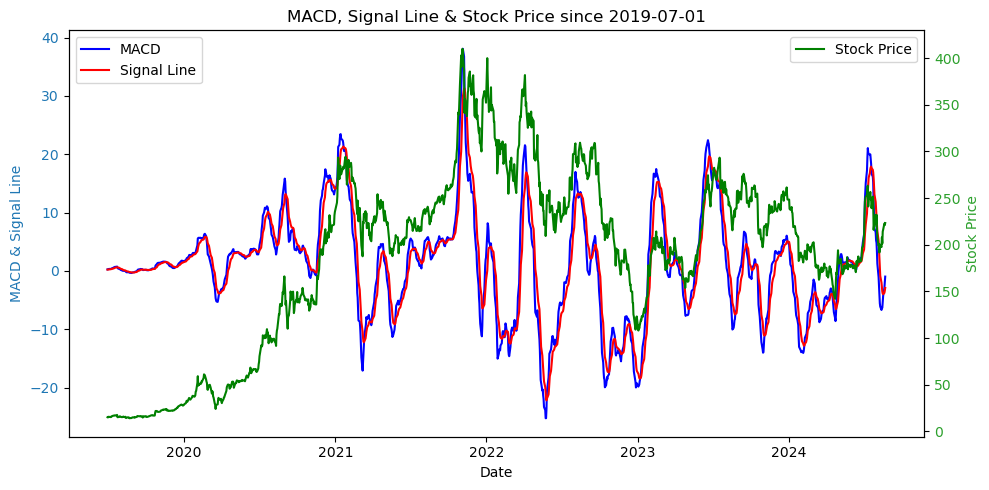

In [57]:
filtered_df = df[naLen:]

fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('MACD & Signal Line', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['MACD'], label='MACD', color='blue')
ax1.plot(filtered_df.index, filtered_df['Signal_Line'], label='Signal Line', color='red')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  
ax2.set_ylabel('Stock Price', color='tab:green')  
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"MACD, Signal Line & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  
plt.show()

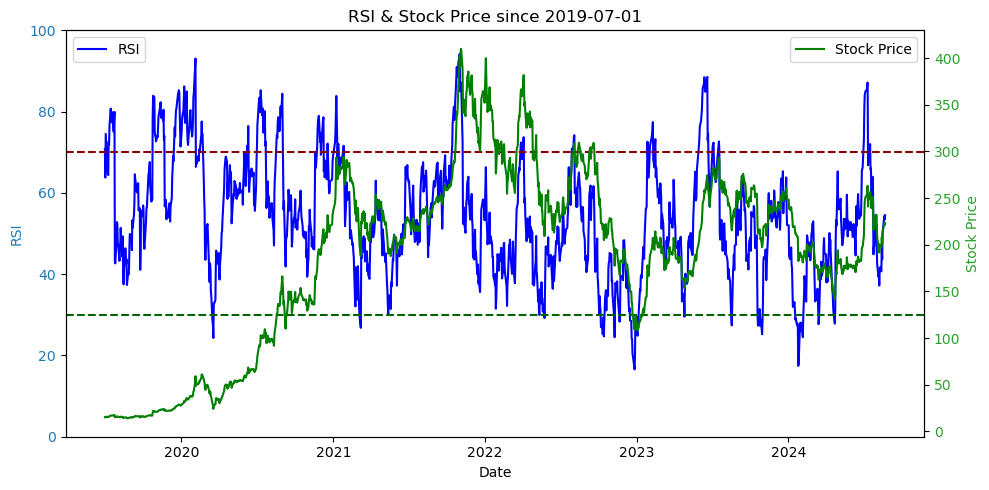

In [58]:
# Plotting RSI and stock price
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel('Date')
ax1.set_ylabel('RSI', color='tab:blue')
ax1.plot(filtered_df.index, filtered_df['RSI'], label='RSI', color='blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.set_ylim(0, 100)
ax1.legend(loc='upper left')
ax1.axhline(y=70, color='darkred', linestyle='--')  # Overbought level
ax1.axhline(y=30, color='darkgreen', linestyle='--')  # Oversold level

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Stock Price', color='tab:green')  # we already handled the x-label with ax1
ax2.plot(filtered_df.index, filtered_df['Close'], label='Stock Price', color='green')
ax2.tick_params(axis='y', labelcolor='tab:green')
ax2.legend(loc='upper right')

plt.title(f"RSI & Stock Price since {filtered_df.index[0].strftime('%Y-%m-%d')}")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability if needed
fig.tight_layout()  # Adjust subplot parameters to give specified padding
plt.show()

In [59]:
print(f"Total records are {filtered_df.shape[0]}."
      f"\nNull check \n{filtered_df.isna().sum()}")

Total records are 1295.
Null check 
Open                  0
High                  0
Low                   0
Close                 0
Volume                0
Dividends             0
Stock Splits          0
SMA_1                 0
SMA_2                 0
SMA_position          0
SMA_return            0
SMA_strat             0
SMA_cum_strat         0
SMA_cum_strat_max     0
momentum_return       0
momentum_position     0
momentum_strat        7
mean_rev_SMA         29
mean_rev_distance    29
mean_rev_position     0
mean_rev_return       0
mean_rev_strat        0
MACD                  0
Signal_Line           0
RSI                   0
dtype: int64


In [60]:
filtered_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits',
       'SMA_1', 'SMA_2', 'SMA_position', 'SMA_return', 'SMA_strat',
       'SMA_cum_strat', 'SMA_cum_strat_max', 'momentum_return',
       'momentum_position', 'momentum_strat', 'mean_rev_SMA',
       'mean_rev_distance', 'mean_rev_position', 'mean_rev_return',
       'mean_rev_strat', 'MACD', 'Signal_Line', 'RSI'],
      dtype='object')

In [61]:
filtered_df = filtered_df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Stock Splits', 'SMA_1',
       'SMA_2', 'SMA_return', 'SMA_strat', 'SMA_cum_strat',
       'SMA_cum_strat_max', 'momentum_return', 
       'momentum_strat', 'mean_rev_SMA', 'mean_rev_distance',
       'mean_rev_return', 'mean_rev_strat'], axis = 1)
filtered_df.columns

Index(['Close', 'Dividends', 'SMA_position', 'momentum_position',
       'mean_rev_position', 'MACD', 'Signal_Line', 'RSI'],
      dtype='object')

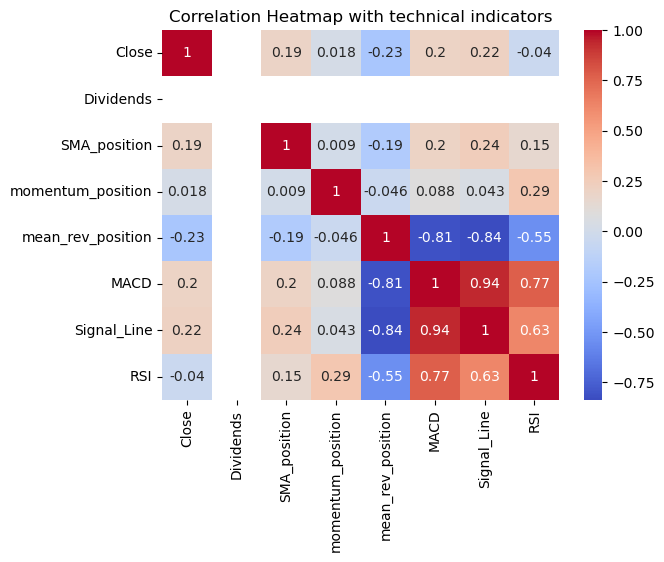

In [62]:
correlation = filtered_df.corr(method='spearman')
sb.heatmap(correlation, annot=True, cmap='coolwarm')

# Add titles and labels
plt.title("Correlation Heatmap with technical indicators")
plt.show()

We can observe that from the seaborn plot that MACD, Signal Line and RSI are all highly correlated to each other and will impact the model's performance.

For a simple approach, we will be using just the 'Closing' price for LSTM. 

<a id="MLtechniquesanddatapartition"></a>
### Part 3. ML techniques and data partition
Recurrent Neural Networks (RNNs) are designed to handle sequences of variable lengths, making them particularly suitable for tasks like predicting future values in a sequence. They maintain an internal state that can capture information about previous elements in the sequence, allowing them to remember important parts and potentially forget less crucial details over time.


However, traditional RNNs suffer from challenges related to the vanishing and exploding gradient problems, especially when processing long sequences. These issues hinder RNN’s ability to learn from distant past information in the sequence.


To address this, __Long Short-Term Memory (LSTM)__ networks were introduced. LSTMs are a special kind of RNN that can learn and remember over long sequences and are not as susceptible to the vanishing gradient problem as standard RNNs. This makes them more efficient at capturing long-term dependencies in sequence data.

Allocation of data for training are
1. Train: 90%
2. Test: 10%

Project is a regression problem, hence we will be testing out performance metrics.
1. Mean Square Error (MSE)

In [65]:
# 2. Preprocess the Data
df = tsla_price[['Close']]

scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(df.values.reshape(-1, 1))

Hyperparameters for the LSTM are: {'hidden_dim': 128, 'num_layers': 2, 'dropout': 0.2, 'learning_rate': 0.01, 'epochs': 100, 'window': 10}
Epoch [50/100], Training loss: 0.0046
Epoch [100/100], Training loss: 0.0024
MSE Test Loss: 0.0024



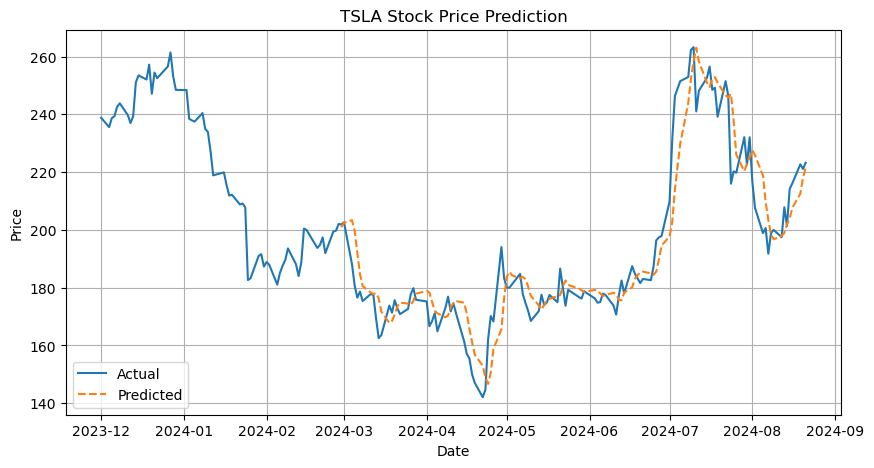

In [66]:
# Define LSTM model
class LSTM(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, num_layers, dropout):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])

# Prepare data function
def prepare_data(data_normalized, window):
    data_len = len(data_normalized)
    train_ratio = 0.90
    train_len = int(data_len * train_ratio)

    X_train, y_train = [], []
    X_test, y_test = [], []

    # Training data
    for i in range(train_len - window):
        X_train.append(data_normalized[i:i + window])
        y_train.append(data_normalized[i + window])

    # Test data 
    for i in range(train_len, data_len - window):
        X_test.append(data_normalized[i:i + window])
        y_test.append(data_normalized[i + window])

#     print(f"Training Size: {len(X_train)}, Testing Size: {len(X_test)}, Window Size: {window}")
    
    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test)

# Plot prediction against actual data
def plot(tsla_price, predicted_prices, len_test):
    plot_len = int(len_test * 1.5)
    
    plt.figure(figsize=(10, 5))
    plt.plot(tsla_price.index[-plot_len:], tsla_price['Close'].values[-plot_len:], label='Actual')
    plt.plot(tsla_price.index[-len_test:], predicted_prices, label='Predicted', linestyle='dashed')
    
    plt.title('TSLA Stock Price Prediction')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main function
def main(X_train, y_train, X_test, y_test, hyperparameters):
    hidden_dim = hyperparameters['hidden_dim']
    num_layers = hyperparameters['num_layers']
    dropout = hyperparameters['dropout']
    learning_rate = hyperparameters['learning_rate']
    epochs = hyperparameters['epochs']
    print(f"Hyperparameters for the LSTM are: {hyperparameters}")

    # Convert numpy arrays to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
    
    torch.manual_seed(42)

    # Initialize model
    model = LSTM(input_dim=1, output_dim=1, 
                 hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Training loss: {loss.item():.4f}')

    # Use the last window from the test set to predict the entire test set
    model.eval()
    with torch.no_grad():
        predicted_prices = []
        for i in range(len(X_test)):
            input_data = X_test[i].unsqueeze(0)
            output = model(input_data)
            predicted_prices.append(output.item())
    
    # Convert predicted_prices to a PyTorch tensor and ensure it matches y_test shape
    predicted_prices_tensor = torch.tensor(predicted_prices, dtype=torch.float32).view(-1, 1)
    
    # Compute MSE
    mse_loss = criterion(predicted_prices_tensor, y_test)
    print(f"MSE Test Loss: {mse_loss.item():.4f}\n")

    # Convert predicted_prices to numpy array
    predicted_prices = scaler.inverse_transform(predicted_prices_tensor.numpy().reshape(-1, 1)).flatten()

    return predicted_prices, mse_loss.item(), loss.item(), model

if __name__ == '__main__':
    hyperparameters = {
        'hidden_dim': 128, # LSTM hyperparameter
        'num_layers': 2, # LSTM hyperparameter
        'dropout': 0.2, # LSTM hyperparameter
        'learning_rate': 0.01, # ADAM parameters
        'epochs': 100, # training # ADAM parameters
        'window': 10  # Feature engineering as input config (Data partition)
    }
    
    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
    # Plot prediction
    plot(df, predicted_prices, len(X_test))


Test the initial model

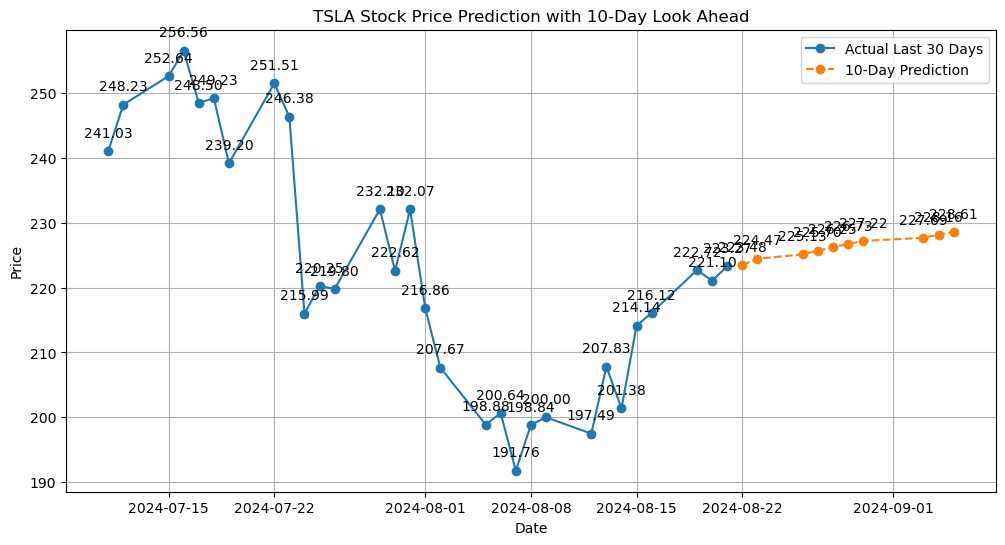

,Date,Predicted
0,2024-08-22 00:00:00+00:00,223.480645
1,2024-08-23 00:00:00+00:00,224.474490
2,2024-08-26 00:00:00+00:00,225.134315
3,2024-08-27 00:00:00+00:00,225.702112
4,2024-08-28 00:00:00+00:00,226.249794
5,2024-08-29 00:00:00+00:00,226.732160
6,2024-08-30 00:00:00+00:00,227.221967
7,2024-09-03 00:00:00+00:00,227.689462
8,2024-09-04 00:00:00+00:00,228.159663
9,2024-09-05 00:00:00+00:00,228.612248


In [68]:
import pandas_market_calendars as mcal

# Function to predict n days ahead
def predict_n_days_ahead(model, data, window, scaler, n_days):
    model.eval()
    with torch.no_grad():
        predictions = []
        input_seq = torch.tensor(data[-window:], dtype=torch.float32).unsqueeze(0)
        for _ in range(n_days):
            output = model(input_seq)
            predictions.append(output.item())
            output = output.view(1, 1, -1)
            input_seq = torch.cat((input_seq[:, 1:, :], output), dim=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Function to plot actual and predicted values for n days
def plot_actual_and_predicted(df, future_predictions, n_days):
    last_n_days_actual = df['Close'].values[-((3*n_days)):]

    # Get the trading calendar for the stock market
    nyse = mcal.get_calendar('NYSE')
    next_trading_days = nyse.valid_days(start_date=df.index[-1], end_date=pd.Timestamp.today() + pd.DateOffset(days=2*n_days))

    date_range_future = next_trading_days[1:n_days+1]
    future_df = pd.DataFrame({'Date': date_range_future, 'Predicted': future_predictions})

    # Plotting the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-(3*n_days):], last_n_days_actual, label=f'Actual Last {(3*n_days)} Days', marker='o')
    plt.plot(date_range_future, future_predictions, label=f'{n_days}-Day Prediction', linestyle='dashed', marker='o')

    # Annotate actual values
    for i, txt in enumerate(last_n_days_actual):
        plt.annotate(f'{txt:.2f}', (df.index[-(3*n_days) + i], last_n_days_actual[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Annotate predicted values
    for i, txt in enumerate(future_predictions):
        plt.annotate(f'{txt:.2f}', (date_range_future[i], future_predictions[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'TSLA Stock Price Prediction with {n_days}-Day Look Ahead')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return future_df

# Real testing
n_days = 10  # Change this to any number of days you want to predict
future_predictions = predict_n_days_ahead(model, data_normalized, hyperparameters['window'], scaler, n_days)

future_df = plot_actual_and_predicted(df, future_predictions, n_days)
future_df

<a id="OptimizeLSTMhyperparameters"></a>

### Part 4. Optimize LSTM hyperparameters, training loop parameter and window size

Using Optuna, we can create a study and trial on a objective function of parameters that searches for global minimal. By setting the ranges that we are interested in searching for, Optuna automates the process of tuning which can be time-consuming and complex. Optuna uses Bayesian Optimization to find the best hyperparameters more effectively than random or grid search. This allows for a more efficient search and less computional cost. Optuna is designed to be highly Pythonic, making it easier to integrate and use within Python-based projects like this.

<u>Total of 6 parameters needs optimizing.</u>

LSTM: Hidden Dimensions, Number of Layers, Dropout
Training Loop: Learning rate, epoch
Data Partition: Window

"Window" refers to the size of sliding windows used to create input sequence from the time series data.

For example, data points [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] and a window size of 3.
- [1, 2, 3]
- [2, 3, 4]
- [3, 4, 5]
-     :
- [8, 9, 10]

[I 2024-08-22 14:10:52,389] A new study created in memory with name: no-name-741a076f-3596-4ba4-8b59-5c4020283956


Hyperparameters for the LSTM are: {'hidden_dim': 197, 'num_layers': 2, 'dropout': 0.18643221690407047, 'learning_rate': 0.0379268442912409, 'epochs': 168, 'window': 15}
Epoch [50/168], Training loss: 0.0237
Epoch [100/168], Training loss: 0.0205
Epoch [150/168], Training loss: 0.0271


[I 2024-08-22 14:12:52,336] Trial 0 finished with value: 0.014854738488793373 and parameters: {'hidden_dim': 197, 'num_layers': 2, 'dropout': 0.18643221690407047, 'learning_rate': 0.0379268442912409, 'epochs': 168, 'window': 15}. Best is trial 0 with value: 0.014854738488793373.


MSE Test Loss: 0.0140

Hyperparameters for the LSTM are: {'hidden_dim': 126, 'num_layers': 3, 'dropout': 0.471658172537478, 'learning_rate': 0.00010205317461118469, 'epochs': 196, 'window': 7}
Epoch [50/196], Training loss: 0.2326
Epoch [100/196], Training loss: 0.0186
Epoch [150/196], Training loss: 0.0091


[I 2024-08-22 14:13:39,070] Trial 1 finished with value: 0.006853894796222448 and parameters: {'hidden_dim': 126, 'num_layers': 3, 'dropout': 0.471658172537478, 'learning_rate': 0.00010205317461118469, 'epochs': 196, 'window': 7}. Best is trial 1 with value: 0.006853894796222448.


MSE Test Loss: 0.0068

Hyperparameters for the LSTM are: {'hidden_dim': 268, 'num_layers': 2, 'dropout': 0.42821746497402535, 'learning_rate': 0.002829518301358838, 'epochs': 87, 'window': 12}
Epoch [50/87], Training loss: 0.0070


[I 2024-08-22 14:15:00,469] Trial 2 finished with value: 0.004582475870847702 and parameters: {'hidden_dim': 268, 'num_layers': 2, 'dropout': 0.42821746497402535, 'learning_rate': 0.002829518301358838, 'epochs': 87, 'window': 12}. Best is trial 2 with value: 0.004582475870847702.


MSE Test Loss: 0.0046

Hyperparameters for the LSTM are: {'hidden_dim': 157, 'num_layers': 1, 'dropout': 0.20091050861847234, 'learning_rate': 0.0005091544814405751, 'epochs': 238, 'window': 11}
Epoch [50/238], Training loss: 0.0123
Epoch [100/238], Training loss: 0.0066
Epoch [150/238], Training loss: 0.0061
Epoch [200/238], Training loss: 0.0054


[I 2024-08-22 14:15:33,725] Trial 3 finished with value: 0.0051236574072390795 and parameters: {'hidden_dim': 157, 'num_layers': 1, 'dropout': 0.20091050861847234, 'learning_rate': 0.0005091544814405751, 'epochs': 238, 'window': 11}. Best is trial 2 with value: 0.004582475870847702.


MSE Test Loss: 0.0050

Hyperparameters for the LSTM are: {'hidden_dim': 274, 'num_layers': 1, 'dropout': 0.43639431814807694, 'learning_rate': 0.014145465118865688, 'epochs': 103, 'window': 13}
Epoch [50/103], Training loss: 0.0024
Epoch [100/103], Training loss: 0.0019


[I 2024-08-22 14:16:21,082] Trial 4 finished with value: 0.001814531278796494 and parameters: {'hidden_dim': 274, 'num_layers': 1, 'dropout': 0.43639431814807694, 'learning_rate': 0.014145465118865688, 'epochs': 103, 'window': 13}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 242, 'num_layers': 1, 'dropout': 0.3748799541239073, 'learning_rate': 0.005444270812294891, 'epochs': 178, 'window': 16}
Epoch [50/178], Training loss: 0.0084
Epoch [100/178], Training loss: 0.0039
Epoch [150/178], Training loss: 0.0031


[I 2024-08-22 14:17:31,498] Trial 5 finished with value: 0.0032597207464277744 and parameters: {'hidden_dim': 242, 'num_layers': 1, 'dropout': 0.3748799541239073, 'learning_rate': 0.005444270812294891, 'epochs': 178, 'window': 16}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0032

Hyperparameters for the LSTM are: {'hidden_dim': 275, 'num_layers': 1, 'dropout': 0.438176791829769, 'learning_rate': 0.0001810313397775499, 'epochs': 193, 'window': 12}
Epoch [50/193], Training loss: 0.0182
Epoch [100/193], Training loss: 0.0081
Epoch [150/193], Training loss: 0.0077


[I 2024-08-22 14:18:42,234] Trial 6 finished with value: 0.007416790351271629 and parameters: {'hidden_dim': 275, 'num_layers': 1, 'dropout': 0.438176791829769, 'learning_rate': 0.0001810313397775499, 'epochs': 193, 'window': 12}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0074

Hyperparameters for the LSTM are: {'hidden_dim': 249, 'num_layers': 3, 'dropout': 0.30096265113216336, 'learning_rate': 0.0005482865822079131, 'epochs': 190, 'window': 9}
Epoch [50/190], Training loss: 0.0089
Epoch [100/190], Training loss: 0.0067
Epoch [150/190], Training loss: 0.0061


[I 2024-08-22 14:21:50,266] Trial 7 finished with value: 0.00567964930087328 and parameters: {'hidden_dim': 249, 'num_layers': 3, 'dropout': 0.30096265113216336, 'learning_rate': 0.0005482865822079131, 'epochs': 190, 'window': 9}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0056

Hyperparameters for the LSTM are: {'hidden_dim': 134, 'num_layers': 2, 'dropout': 0.4622019420082242, 'learning_rate': 0.005071861355724735, 'epochs': 279, 'window': 12}
Epoch [50/279], Training loss: 0.0080
Epoch [100/279], Training loss: 0.0040
Epoch [150/279], Training loss: 0.0028
Epoch [200/279], Training loss: 0.0024
Epoch [250/279], Training loss: 0.0021


[I 2024-08-22 14:23:09,643] Trial 8 finished with value: 0.0018657819018699229 and parameters: {'hidden_dim': 134, 'num_layers': 2, 'dropout': 0.4622019420082242, 'learning_rate': 0.005071861355724735, 'epochs': 279, 'window': 12}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0019

Hyperparameters for the LSTM are: {'hidden_dim': 89, 'num_layers': 2, 'dropout': 0.2632754500710869, 'learning_rate': 0.06151589561439321, 'epochs': 222, 'window': 20}
Epoch [50/222], Training loss: 0.0944
Epoch [100/222], Training loss: 0.0074
Epoch [150/222], Training loss: 0.0069
Epoch [200/222], Training loss: 0.0026


[I 2024-08-22 14:24:05,311] Trial 9 finished with value: 0.004076332785189152 and parameters: {'hidden_dim': 89, 'num_layers': 2, 'dropout': 0.2632754500710869, 'learning_rate': 0.06151589561439321, 'epochs': 222, 'window': 20}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0032

Hyperparameters for the LSTM are: {'hidden_dim': 205, 'num_layers': 1, 'dropout': 0.10393240165334469, 'learning_rate': 0.014081544385154833, 'epochs': 63, 'window': 5}
Epoch [50/63], Training loss: 0.0051


[I 2024-08-22 14:24:11,991] Trial 10 finished with value: 0.004363399697467685 and parameters: {'hidden_dim': 205, 'num_layers': 1, 'dropout': 0.10393240165334469, 'learning_rate': 0.014081544385154833, 'epochs': 63, 'window': 5}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0041

Hyperparameters for the LSTM are: {'hidden_dim': 84, 'num_layers': 2, 'dropout': 0.49257283135804825, 'learning_rate': 0.004322534596301642, 'epochs': 295, 'window': 15}
Epoch [50/295], Training loss: 0.0061
Epoch [100/295], Training loss: 0.0040
Epoch [150/295], Training loss: 0.0029
Epoch [200/295], Training loss: 0.0025
Epoch [250/295], Training loss: 0.0022


[I 2024-08-22 14:25:04,482] Trial 11 finished with value: 0.0019040046609006822 and parameters: {'hidden_dim': 84, 'num_layers': 2, 'dropout': 0.49257283135804825, 'learning_rate': 0.004322534596301642, 'epochs': 295, 'window': 15}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0019

Hyperparameters for the LSTM are: {'hidden_dim': 144, 'num_layers': 3, 'dropout': 0.3750362125898554, 'learning_rate': 0.015429477644994102, 'epochs': 115, 'window': 18}
Epoch [50/115], Training loss: 0.2524
Epoch [100/115], Training loss: 0.2508


[I 2024-08-22 14:26:28,514] Trial 12 finished with value: 0.13609721418470144 and parameters: {'hidden_dim': 144, 'num_layers': 3, 'dropout': 0.3750362125898554, 'learning_rate': 0.015429477644994102, 'epochs': 115, 'window': 18}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0215

Hyperparameters for the LSTM are: {'hidden_dim': 299, 'num_layers': 1, 'dropout': 0.3798147261879375, 'learning_rate': 0.0016897722132330566, 'epochs': 130, 'window': 9}
Epoch [50/130], Training loss: 0.0051
Epoch [100/130], Training loss: 0.0039


[I 2024-08-22 14:27:11,537] Trial 13 finished with value: 0.003419247455894947 and parameters: {'hidden_dim': 299, 'num_layers': 1, 'dropout': 0.3798147261879375, 'learning_rate': 0.0016897722132330566, 'epochs': 130, 'window': 9}. Best is trial 4 with value: 0.001814531278796494.


MSE Test Loss: 0.0034

Hyperparameters for the LSTM are: {'hidden_dim': 50, 'num_layers': 2, 'dropout': 0.317692239620582, 'learning_rate': 0.013959177178128019, 'epochs': 295, 'window': 14}
Epoch [50/295], Training loss: 0.0039
Epoch [100/295], Training loss: 0.0026
Epoch [150/295], Training loss: 0.0023
Epoch [200/295], Training loss: 0.0021
Epoch [250/295], Training loss: 0.0020


[I 2024-08-22 14:27:35,859] Trial 14 finished with value: 0.0017924350686371326 and parameters: {'hidden_dim': 50, 'num_layers': 2, 'dropout': 0.317692239620582, 'learning_rate': 0.013959177178128019, 'epochs': 295, 'window': 14}. Best is trial 14 with value: 0.0017924350686371326.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 57, 'num_layers': 1, 'dropout': 0.3172891727106349, 'learning_rate': 0.018094280416487467, 'epochs': 142, 'window': 14}
Epoch [50/142], Training loss: 0.0025
Epoch [100/142], Training loss: 0.0020


[I 2024-08-22 14:27:42,247] Trial 15 finished with value: 0.0017969462205655873 and parameters: {'hidden_dim': 57, 'num_layers': 1, 'dropout': 0.3172891727106349, 'learning_rate': 0.018094280416487467, 'epochs': 142, 'window': 14}. Best is trial 14 with value: 0.0017924350686371326.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 50, 'num_layers': 3, 'dropout': 0.306412264783375, 'learning_rate': 0.09454656807313393, 'epochs': 144, 'window': 17}
Epoch [50/144], Training loss: 0.0050
Epoch [100/144], Training loss: 0.0020


[I 2024-08-22 14:28:05,055] Trial 16 finished with value: 0.002300293534062803 and parameters: {'hidden_dim': 50, 'num_layers': 3, 'dropout': 0.306412264783375, 'learning_rate': 0.09454656807313393, 'epochs': 144, 'window': 17}. Best is trial 14 with value: 0.0017924350686371326.


MSE Test Loss: 0.0021

Hyperparameters for the LSTM are: {'hidden_dim': 58, 'num_layers': 2, 'dropout': 0.26397872050406296, 'learning_rate': 0.03189220088610983, 'epochs': 260, 'window': 14}
Epoch [50/260], Training loss: 0.0025
Epoch [100/260], Training loss: 0.0019
Epoch [150/260], Training loss: 0.0017
Epoch [200/260], Training loss: 0.0017
Epoch [250/260], Training loss: 0.0016


[I 2024-08-22 14:28:30,626] Trial 17 finished with value: 0.0015373807400465012 and parameters: {'hidden_dim': 58, 'num_layers': 2, 'dropout': 0.26397872050406296, 'learning_rate': 0.03189220088610983, 'epochs': 260, 'window': 14}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0015

Hyperparameters for the LSTM are: {'hidden_dim': 103, 'num_layers': 2, 'dropout': 0.2520353373184402, 'learning_rate': 0.03062268189518439, 'epochs': 257, 'window': 20}
Epoch [50/257], Training loss: 0.2560
Epoch [100/257], Training loss: 0.2467
Epoch [150/257], Training loss: 0.1111
Epoch [200/257], Training loss: 0.0168
Epoch [250/257], Training loss: 0.0087


[I 2024-08-22 14:29:51,132] Trial 18 finished with value: 0.004878864856436849 and parameters: {'hidden_dim': 103, 'num_layers': 2, 'dropout': 0.2520353373184402, 'learning_rate': 0.03062268189518439, 'epochs': 257, 'window': 20}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0040

Hyperparameters for the LSTM are: {'hidden_dim': 73, 'num_layers': 2, 'dropout': 0.1967216434213232, 'learning_rate': 0.030275171904909463, 'epochs': 265, 'window': 10}
Epoch [50/265], Training loss: 0.0049
Epoch [100/265], Training loss: 0.0023
Epoch [150/265], Training loss: 0.0019
Epoch [200/265], Training loss: 0.0017
Epoch [250/265], Training loss: 0.0016


[I 2024-08-22 14:30:16,125] Trial 19 finished with value: 0.0015460294089280069 and parameters: {'hidden_dim': 73, 'num_layers': 2, 'dropout': 0.1967216434213232, 'learning_rate': 0.030275171904909463, 'epochs': 265, 'window': 10}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0015

Hyperparameters for the LSTM are: {'hidden_dim': 111, 'num_layers': 3, 'dropout': 0.14634968401409293, 'learning_rate': 0.029122545284300194, 'epochs': 261, 'window': 10}
Epoch [50/261], Training loss: 0.0632
Epoch [100/261], Training loss: 0.0148
Epoch [150/261], Training loss: 0.0346
Epoch [200/261], Training loss: 0.0137
Epoch [250/261], Training loss: 0.0102


[I 2024-08-22 14:31:37,099] Trial 20 finished with value: 0.012048911303281784 and parameters: {'hidden_dim': 111, 'num_layers': 3, 'dropout': 0.14634968401409293, 'learning_rate': 0.029122545284300194, 'epochs': 261, 'window': 10}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0112

Hyperparameters for the LSTM are: {'hidden_dim': 72, 'num_layers': 2, 'dropout': 0.2389663653156917, 'learning_rate': 0.009249928989141084, 'epochs': 296, 'window': 14}
Epoch [50/296], Training loss: 0.0039
Epoch [100/296], Training loss: 0.0025
Epoch [150/296], Training loss: 0.0034
Epoch [200/296], Training loss: 0.0018
Epoch [250/296], Training loss: 0.0016


[I 2024-08-22 14:32:15,248] Trial 21 finished with value: 0.0017170803039334714 and parameters: {'hidden_dim': 72, 'num_layers': 2, 'dropout': 0.2389663653156917, 'learning_rate': 0.009249928989141084, 'epochs': 296, 'window': 14}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0016

Hyperparameters for the LSTM are: {'hidden_dim': 78, 'num_layers': 2, 'dropout': 0.23101688747274815, 'learning_rate': 0.007165008662295883, 'epochs': 221, 'window': 8}
Epoch [50/221], Training loss: 0.0060
Epoch [100/221], Training loss: 0.0041
Epoch [150/221], Training loss: 0.0029
Epoch [200/221], Training loss: 0.0024


[I 2024-08-22 14:32:35,573] Trial 22 finished with value: 0.0024263699306175113 and parameters: {'hidden_dim': 78, 'num_layers': 2, 'dropout': 0.23101688747274815, 'learning_rate': 0.007165008662295883, 'epochs': 221, 'window': 8}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0024

Hyperparameters for the LSTM are: {'hidden_dim': 80, 'num_layers': 2, 'dropout': 0.16925924639726428, 'learning_rate': 0.06803154639556797, 'epochs': 266, 'window': 18}
Epoch [50/266], Training loss: 0.0204
Epoch [100/266], Training loss: 0.0098
Epoch [150/266], Training loss: 0.0065
Epoch [200/266], Training loss: 0.0044
Epoch [250/266], Training loss: 0.0047


[I 2024-08-22 14:34:41,956] Trial 23 finished with value: 0.0029183425940573215 and parameters: {'hidden_dim': 80, 'num_layers': 2, 'dropout': 0.16925924639726428, 'learning_rate': 0.06803154639556797, 'epochs': 266, 'window': 18}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0024

Hyperparameters for the LSTM are: {'hidden_dim': 112, 'num_layers': 2, 'dropout': 0.22371885225925287, 'learning_rate': 0.008698956972160743, 'epochs': 242, 'window': 11}
Epoch [50/242], Training loss: 0.0066
Epoch [100/242], Training loss: 0.0034
Epoch [150/242], Training loss: 0.0027
Epoch [200/242], Training loss: 0.0023


[I 2024-08-22 14:35:26,848] Trial 24 finished with value: 0.0029082056134939194 and parameters: {'hidden_dim': 112, 'num_layers': 2, 'dropout': 0.22371885225925287, 'learning_rate': 0.008698956972160743, 'epochs': 242, 'window': 11}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0029

Hyperparameters for the LSTM are: {'hidden_dim': 169, 'num_layers': 2, 'dropout': 0.2730311195209279, 'learning_rate': 0.034561462054407605, 'epochs': 300, 'window': 14}
Epoch [50/300], Training loss: 0.0368
Epoch [100/300], Training loss: 0.0051
Epoch [150/300], Training loss: 0.0033
Epoch [200/300], Training loss: 0.0025
Epoch [250/300], Training loss: 0.0029


[I 2024-08-22 14:37:46,372] Trial 25 finished with value: 0.009334427304565907 and parameters: {'hidden_dim': 169, 'num_layers': 2, 'dropout': 0.2730311195209279, 'learning_rate': 0.034561462054407605, 'epochs': 300, 'window': 14}. Best is trial 17 with value: 0.0015373807400465012.


Epoch [300/300], Training loss: 0.0045
MSE Test Loss: 0.0077

Hyperparameters for the LSTM are: {'hidden_dim': 69, 'num_layers': 2, 'dropout': 0.13339051081820566, 'learning_rate': 0.0015979779113527994, 'epochs': 275, 'window': 6}
Epoch [50/275], Training loss: 0.0056
Epoch [100/275], Training loss: 0.0049
Epoch [150/275], Training loss: 0.0046
Epoch [200/275], Training loss: 0.0044
Epoch [250/275], Training loss: 0.0041


[I 2024-08-22 14:38:03,378] Trial 26 finished with value: 0.0038556724321097136 and parameters: {'hidden_dim': 69, 'num_layers': 2, 'dropout': 0.13339051081820566, 'learning_rate': 0.0015979779113527994, 'epochs': 275, 'window': 6}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0038

Hyperparameters for the LSTM are: {'hidden_dim': 97, 'num_layers': 2, 'dropout': 0.2238723507226563, 'learning_rate': 0.0543144486123179, 'epochs': 242, 'window': 10}
Epoch [50/242], Training loss: 0.0060
Epoch [100/242], Training loss: 0.0042
Epoch [150/242], Training loss: 0.0102
Epoch [200/242], Training loss: 0.0030


[I 2024-08-22 14:38:37,570] Trial 27 finished with value: 0.004443128942511976 and parameters: {'hidden_dim': 97, 'num_layers': 2, 'dropout': 0.2238723507226563, 'learning_rate': 0.0543144486123179, 'epochs': 242, 'window': 10}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0040

Hyperparameters for the LSTM are: {'hidden_dim': 68, 'num_layers': 3, 'dropout': 0.280879386680707, 'learning_rate': 0.023134395142238553, 'epochs': 214, 'window': 13}
Epoch [50/214], Training loss: 0.0038
Epoch [100/214], Training loss: 0.0020
Epoch [150/214], Training loss: 0.0017
Epoch [200/214], Training loss: 0.0017


[I 2024-08-22 14:39:16,368] Trial 28 finished with value: 0.0016104048117995262 and parameters: {'hidden_dim': 68, 'num_layers': 3, 'dropout': 0.280879386680707, 'learning_rate': 0.023134395142238553, 'epochs': 214, 'window': 13}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0016

Hyperparameters for the LSTM are: {'hidden_dim': 196, 'num_layers': 3, 'dropout': 0.34388757289730204, 'learning_rate': 0.024282167342006764, 'epochs': 214, 'window': 16}
Epoch [50/214], Training loss: 0.0335
Epoch [100/214], Training loss: 0.0245
Epoch [150/214], Training loss: 0.0246
Epoch [200/214], Training loss: 0.0239


[I 2024-08-22 14:46:50,321] Trial 29 finished with value: 0.023104878142476082 and parameters: {'hidden_dim': 196, 'num_layers': 3, 'dropout': 0.34388757289730204, 'learning_rate': 0.024282167342006764, 'epochs': 214, 'window': 16}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0229

Hyperparameters for the LSTM are: {'hidden_dim': 65, 'num_layers': 3, 'dropout': 0.18908684609975612, 'learning_rate': 0.04676034636130361, 'epochs': 206, 'window': 13}
Epoch [50/206], Training loss: 0.2530
Epoch [100/206], Training loss: 0.2530
Epoch [150/206], Training loss: 0.2529
Epoch [200/206], Training loss: 0.2551


[I 2024-08-22 14:48:46,506] Trial 30 finished with value: 0.13782436959445477 and parameters: {'hidden_dim': 65, 'num_layers': 3, 'dropout': 0.18908684609975612, 'learning_rate': 0.04676034636130361, 'epochs': 206, 'window': 13}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0226

Hyperparameters for the LSTM are: {'hidden_dim': 67, 'num_layers': 2, 'dropout': 0.27419806524319684, 'learning_rate': 0.010530711660163884, 'epochs': 278, 'window': 15}
Epoch [50/278], Training loss: 0.0065
Epoch [100/278], Training loss: 0.0030
Epoch [150/278], Training loss: 0.0024
Epoch [200/278], Training loss: 0.0021
Epoch [250/278], Training loss: 0.0018


[I 2024-08-22 14:49:23,333] Trial 31 finished with value: 0.0016923305811360478 and parameters: {'hidden_dim': 67, 'num_layers': 2, 'dropout': 0.27419806524319684, 'learning_rate': 0.010530711660163884, 'epochs': 278, 'window': 15}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0016

Hyperparameters for the LSTM are: {'hidden_dim': 124, 'num_layers': 3, 'dropout': 0.2639606340876255, 'learning_rate': 0.024519409636158587, 'epochs': 250, 'window': 15}
Epoch [50/250], Training loss: 0.2521
Epoch [100/250], Training loss: 0.2521
Epoch [150/250], Training loss: 0.2521
Epoch [200/250], Training loss: 0.2521
Epoch [250/250], Training loss: 0.2521
MSE Test Loss: 0.0210



[I 2024-08-22 15:00:12,862] Trial 32 finished with value: 0.13655502907931805 and parameters: {'hidden_dim': 124, 'num_layers': 3, 'dropout': 0.2639606340876255, 'learning_rate': 0.024519409636158587, 'epochs': 250, 'window': 15}. Best is trial 17 with value: 0.0015373807400465012.


Hyperparameters for the LSTM are: {'hidden_dim': 98, 'num_layers': 2, 'dropout': 0.27950126086392096, 'learning_rate': 0.0982034641070395, 'epochs': 279, 'window': 16}
Epoch [50/279], Training loss: 0.2519
Epoch [100/279], Training loss: 0.2517
Epoch [150/279], Training loss: 0.2516
Epoch [200/279], Training loss: 0.2516
Epoch [250/279], Training loss: 0.2516


[I 2024-08-22 15:06:45,858] Trial 33 finished with value: 0.13640532921999693 and parameters: {'hidden_dim': 98, 'num_layers': 2, 'dropout': 0.27950126086392096, 'learning_rate': 0.0982034641070395, 'epochs': 279, 'window': 16}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0212

Hyperparameters for the LSTM are: {'hidden_dim': 62, 'num_layers': 2, 'dropout': 0.2143353923781836, 'learning_rate': 0.009681334561856037, 'epochs': 234, 'window': 11}
Epoch [50/234], Training loss: 0.0041
Epoch [100/234], Training loss: 0.0026
Epoch [150/234], Training loss: 0.0022
Epoch [200/234], Training loss: 0.0019


[I 2024-08-22 15:07:07,917] Trial 34 finished with value: 0.0016930189449340105 and parameters: {'hidden_dim': 62, 'num_layers': 2, 'dropout': 0.2143353923781836, 'learning_rate': 0.009681334561856037, 'epochs': 234, 'window': 11}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 125, 'num_layers': 2, 'dropout': 0.34284883989405596, 'learning_rate': 0.02084875668514258, 'epochs': 273, 'window': 13}
Epoch [50/273], Training loss: 0.0066
Epoch [100/273], Training loss: 0.0029
Epoch [150/273], Training loss: 0.0025
Epoch [200/273], Training loss: 0.0022
Epoch [250/273], Training loss: 0.0020


[I 2024-08-22 15:08:22,415] Trial 35 finished with value: 0.0019728182232938707 and parameters: {'hidden_dim': 125, 'num_layers': 2, 'dropout': 0.34284883989405596, 'learning_rate': 0.02084875668514258, 'epochs': 273, 'window': 13}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0019

Hyperparameters for the LSTM are: {'hidden_dim': 88, 'num_layers': 3, 'dropout': 0.1759959120009057, 'learning_rate': 0.04090117123206, 'epochs': 169, 'window': 15}
Epoch [50/169], Training loss: 0.2523
Epoch [100/169], Training loss: 0.2458
Epoch [150/169], Training loss: 0.0365


[I 2024-08-22 15:09:08,992] Trial 36 finished with value: 0.031976303085684776 and parameters: {'hidden_dim': 88, 'num_layers': 3, 'dropout': 0.1759959120009057, 'learning_rate': 0.04090117123206, 'epochs': 169, 'window': 15}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0231

Hyperparameters for the LSTM are: {'hidden_dim': 69, 'num_layers': 2, 'dropout': 0.20225964016891268, 'learning_rate': 0.011727707078682228, 'epochs': 232, 'window': 11}
Epoch [50/232], Training loss: 0.0036
Epoch [100/232], Training loss: 0.0022
Epoch [150/232], Training loss: 0.0019
Epoch [200/232], Training loss: 0.0017


[I 2024-08-22 15:09:33,889] Trial 37 finished with value: 0.0017208888893947005 and parameters: {'hidden_dim': 69, 'num_layers': 2, 'dropout': 0.20225964016891268, 'learning_rate': 0.011727707078682228, 'epochs': 232, 'window': 11}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 148, 'num_layers': 3, 'dropout': 0.28035085844905555, 'learning_rate': 0.04009631948190788, 'epochs': 250, 'window': 8}
Epoch [50/250], Training loss: 0.0142
Epoch [100/250], Training loss: 0.0171
Epoch [150/250], Training loss: 0.0117
Epoch [200/250], Training loss: 0.0053
Epoch [250/250], Training loss: 0.0093
MSE Test Loss: 0.0086



[I 2024-08-22 15:13:27,320] Trial 38 finished with value: 0.008941965643316507 and parameters: {'hidden_dim': 148, 'num_layers': 3, 'dropout': 0.28035085844905555, 'learning_rate': 0.04009631948190788, 'epochs': 250, 'window': 8}. Best is trial 17 with value: 0.0015373807400465012.


Hyperparameters for the LSTM are: {'hidden_dim': 116, 'num_layers': 1, 'dropout': 0.3423146305140643, 'learning_rate': 0.003659344299473597, 'epochs': 204, 'window': 12}
Epoch [50/204], Training loss: 0.0045
Epoch [100/204], Training loss: 0.0031
Epoch [150/204], Training loss: 0.0027
Epoch [200/204], Training loss: 0.0025


[I 2024-08-22 15:13:46,237] Trial 39 finished with value: 0.0026591410860419273 and parameters: {'hidden_dim': 116, 'num_layers': 1, 'dropout': 0.3423146305140643, 'learning_rate': 0.003659344299473597, 'epochs': 204, 'window': 12}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0026

Hyperparameters for the LSTM are: {'hidden_dim': 205, 'num_layers': 2, 'dropout': 0.2449344338381557, 'learning_rate': 0.0025479676391120722, 'epochs': 285, 'window': 17}
Epoch [50/285], Training loss: 0.0090
Epoch [100/285], Training loss: 0.0048
Epoch [150/285], Training loss: 0.0036
Epoch [200/285], Training loss: 0.0030
Epoch [250/285], Training loss: 0.0027


[I 2024-08-22 15:18:06,496] Trial 40 finished with value: 0.002747100661508739 and parameters: {'hidden_dim': 205, 'num_layers': 2, 'dropout': 0.2449344338381557, 'learning_rate': 0.0025479676391120722, 'epochs': 285, 'window': 17}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0027

Hyperparameters for the LSTM are: {'hidden_dim': 61, 'num_layers': 2, 'dropout': 0.20295435575095117, 'learning_rate': 0.0063078389176113425, 'epochs': 231, 'window': 10}
Epoch [50/231], Training loss: 0.0053
Epoch [100/231], Training loss: 0.0029
Epoch [150/231], Training loss: 0.0024
Epoch [200/231], Training loss: 0.0020


[I 2024-08-22 15:18:26,249] Trial 41 finished with value: 0.009131132159382105 and parameters: {'hidden_dim': 61, 'num_layers': 2, 'dropout': 0.20295435575095117, 'learning_rate': 0.0063078389176113425, 'epochs': 231, 'window': 10}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0083

Hyperparameters for the LSTM are: {'hidden_dim': 60, 'num_layers': 2, 'dropout': 0.2856468597650249, 'learning_rate': 0.008846671442829664, 'epochs': 187, 'window': 13}
Epoch [50/187], Training loss: 0.0053
Epoch [100/187], Training loss: 0.0031
Epoch [150/187], Training loss: 0.0026


[I 2024-08-22 15:18:47,122] Trial 42 finished with value: 0.0027230660198256373 and parameters: {'hidden_dim': 60, 'num_layers': 2, 'dropout': 0.2856468597650249, 'learning_rate': 0.008846671442829664, 'epochs': 187, 'window': 13}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0026

Hyperparameters for the LSTM are: {'hidden_dim': 86, 'num_layers': 2, 'dropout': 0.21029235449489417, 'learning_rate': 0.019562513662519408, 'epochs': 261, 'window': 12}
Epoch [50/261], Training loss: 0.0026
Epoch [100/261], Training loss: 0.0021
Epoch [150/261], Training loss: 0.0023
Epoch [200/261], Training loss: 0.0018
Epoch [250/261], Training loss: 0.0017


[I 2024-08-22 15:19:28,120] Trial 43 finished with value: 0.0016274999943561852 and parameters: {'hidden_dim': 86, 'num_layers': 2, 'dropout': 0.21029235449489417, 'learning_rate': 0.019562513662519408, 'epochs': 261, 'window': 12}. Best is trial 17 with value: 0.0015373807400465012.


MSE Test Loss: 0.0016

Hyperparameters for the LSTM are: {'hidden_dim': 85, 'num_layers': 2, 'dropout': 0.158364926734246, 'learning_rate': 0.019690284312967238, 'epochs': 264, 'window': 12}
Epoch [50/264], Training loss: 0.0022
Epoch [100/264], Training loss: 0.0017
Epoch [150/264], Training loss: 0.0016
Epoch [200/264], Training loss: 0.0016
Epoch [250/264], Training loss: 0.0015


[I 2024-08-22 15:20:07,092] Trial 44 finished with value: 0.0015046638436615467 and parameters: {'hidden_dim': 85, 'num_layers': 2, 'dropout': 0.158364926734246, 'learning_rate': 0.019690284312967238, 'epochs': 264, 'window': 12}. Best is trial 44 with value: 0.0015046638436615467.


MSE Test Loss: 0.0015

Hyperparameters for the LSTM are: {'hidden_dim': 86, 'num_layers': 2, 'dropout': 0.1261595713763244, 'learning_rate': 0.06657332466261935, 'epochs': 260, 'window': 11}
Epoch [50/260], Training loss: 0.0124
Epoch [100/260], Training loss: 0.0044
Epoch [150/260], Training loss: 0.0040
Epoch [200/260], Training loss: 0.0127
Epoch [250/260], Training loss: 0.0041


[I 2024-08-22 15:20:43,592] Trial 45 finished with value: 0.0043431411031633615 and parameters: {'hidden_dim': 86, 'num_layers': 2, 'dropout': 0.1261595713763244, 'learning_rate': 0.06657332466261935, 'epochs': 260, 'window': 11}. Best is trial 44 with value: 0.0015046638436615467.


MSE Test Loss: 0.0042

Hyperparameters for the LSTM are: {'hidden_dim': 98, 'num_layers': 2, 'dropout': 0.1614991356379687, 'learning_rate': 0.018853477746474966, 'epochs': 250, 'window': 12}
Epoch [50/250], Training loss: 0.0031
Epoch [100/250], Training loss: 0.0020
Epoch [150/250], Training loss: 0.0018
Epoch [200/250], Training loss: 0.0017


[I 2024-08-22 15:21:28,678] Trial 46 finished with value: 0.0015859214472584426 and parameters: {'hidden_dim': 98, 'num_layers': 2, 'dropout': 0.1614991356379687, 'learning_rate': 0.018853477746474966, 'epochs': 250, 'window': 12}. Best is trial 44 with value: 0.0015046638436615467.


Epoch [250/250], Training loss: 0.0016
MSE Test Loss: 0.0016

Hyperparameters for the LSTM are: {'hidden_dim': 99, 'num_layers': 2, 'dropout': 0.15178291079782533, 'learning_rate': 0.00039001482178104664, 'epochs': 225, 'window': 9}
Epoch [50/225], Training loss: 0.0218
Epoch [100/225], Training loss: 0.0067
Epoch [150/225], Training loss: 0.0064
Epoch [200/225], Training loss: 0.0061


[I 2024-08-22 15:21:58,848] Trial 47 finished with value: 0.006057925056666136 and parameters: {'hidden_dim': 99, 'num_layers': 2, 'dropout': 0.15178291079782533, 'learning_rate': 0.00039001482178104664, 'epochs': 225, 'window': 9}. Best is trial 44 with value: 0.0015046638436615467.


MSE Test Loss: 0.0060

Hyperparameters for the LSTM are: {'hidden_dim': 137, 'num_layers': 1, 'dropout': 0.17591017945886603, 'learning_rate': 0.01608094382827319, 'epochs': 251, 'window': 12}
Epoch [50/251], Training loss: 0.0030
Epoch [100/251], Training loss: 0.0022
Epoch [150/251], Training loss: 0.0020
Epoch [200/251], Training loss: 0.0019


[I 2024-08-22 15:22:28,369] Trial 48 finished with value: 0.00175240432145074 and parameters: {'hidden_dim': 137, 'num_layers': 1, 'dropout': 0.17591017945886603, 'learning_rate': 0.01608094382827319, 'epochs': 251, 'window': 12}. Best is trial 44 with value: 0.0015046638436615467.


Epoch [250/251], Training loss: 0.0018
MSE Test Loss: 0.0017

Hyperparameters for the LSTM are: {'hidden_dim': 76, 'num_layers': 2, 'dropout': 0.11586126774390819, 'learning_rate': 0.028004847232117304, 'epochs': 212, 'window': 13}
Epoch [50/212], Training loss: 0.0029
Epoch [100/212], Training loss: 0.0018
Epoch [150/212], Training loss: 0.0016
Epoch [200/212], Training loss: 0.0017


[I 2024-08-22 15:22:57,253] Trial 49 finished with value: 0.0015900395810604095 and parameters: {'hidden_dim': 76, 'num_layers': 2, 'dropout': 0.11586126774390819, 'learning_rate': 0.028004847232117304, 'epochs': 212, 'window': 13}. Best is trial 44 with value: 0.0015046638436615467.


MSE Test Loss: 0.0015

Best hyperparameters found:  {'hidden_dim': 85, 'num_layers': 2, 'dropout': 0.158364926734246, 'learning_rate': 0.019690284312967238, 'epochs': 264, 'window': 12}
Hyperparameters for the LSTM are: {'hidden_dim': 85, 'num_layers': 2, 'dropout': 0.158364926734246, 'learning_rate': 0.019690284312967238, 'epochs': 264, 'window': 12}
Epoch [50/264], Training loss: 0.0022
Epoch [100/264], Training loss: 0.0017
Epoch [150/264], Training loss: 0.0016
Epoch [200/264], Training loss: 0.0016
Epoch [250/264], Training loss: 0.0015
MSE Test Loss: 0.0015

Model saved to best_model.pth


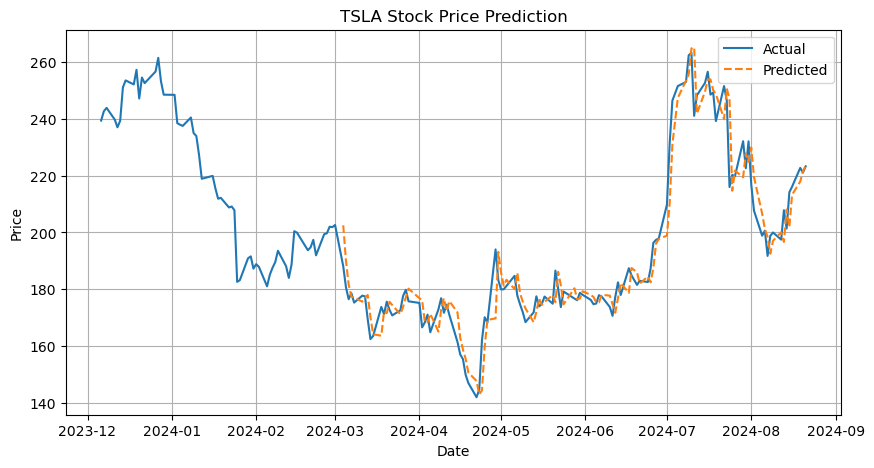

In [70]:
# !pip install optuna
import optuna
from optuna.trial import Trial

# Optuna objective function
def objective(trial: Trial):
    hyperparameters = {
        'hidden_dim': trial.suggest_int('hidden_dim', 50, 300),
        'num_layers': trial.suggest_int('num_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1e-1, log=True),
        'epochs': trial.suggest_int('epochs', 50, 300),
        'window': trial.suggest_int('window', 5, 20)
    }

    X_train, y_train, X_test, y_test = prepare_data(data_normalized, hyperparameters['window'])
    predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, hyperparameters)
    
    # Combine training and validation losses to avoid overfitting
    combined_loss = mse_loss + 0.5 * abs(mse_loss - loss)
    
    return combined_loss

# Run Optuna optimization
if __name__ == '__main__':
    study = optuna.create_study(direction='minimize')
    # Set the number of trials
    study.optimize(objective, n_trials=50)

    best_hyperparameters = study.best_params
    print("Best hyperparameters found: ", best_hyperparameters)

    # Train the final model with the best hyperparameters
    X_train, y_train, X_test, y_test = prepare_data(data_normalized, best_hyperparameters['window'])
    predicted_prices, mse_loss, loss, model = main(X_train, y_train, X_test, y_test, best_hyperparameters)
        
    # Save the best performing model
    model_path = 'best_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'hyperparameters': best_hyperparameters
    }, model_path)
    print(f"Model saved to {model_path}")
    
    # Plot prediction
    plot(df, predicted_prices, len(X_test))

The best hyperparameters and models found after 50 trials of Optuna are saved. Optimization step commented out to avoid over-writting of saved model. 

In [72]:
# Load the saved state dictionary and hyperparameters
checkpoint = torch.load('best_model.pth')
model_state_dict = checkpoint['model_state_dict']
hyperparameters = checkpoint['hyperparameters']

# Initialize the model with the saved hyperparameters
model = LSTM(input_dim=1, output_dim=1, 
             hidden_dim=hyperparameters['hidden_dim'], 
             num_layers=hyperparameters['num_layers'], 
             dropout=hyperparameters['dropout'])

# Load the state dictionary into the model
model.load_state_dict(model_state_dict)

print("Model and hyperparameters loaded successfully")

Model and hyperparameters loaded successfully


C:\Users\keith\AppData\Local\Temp\ipykernel_24616\2767740525.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


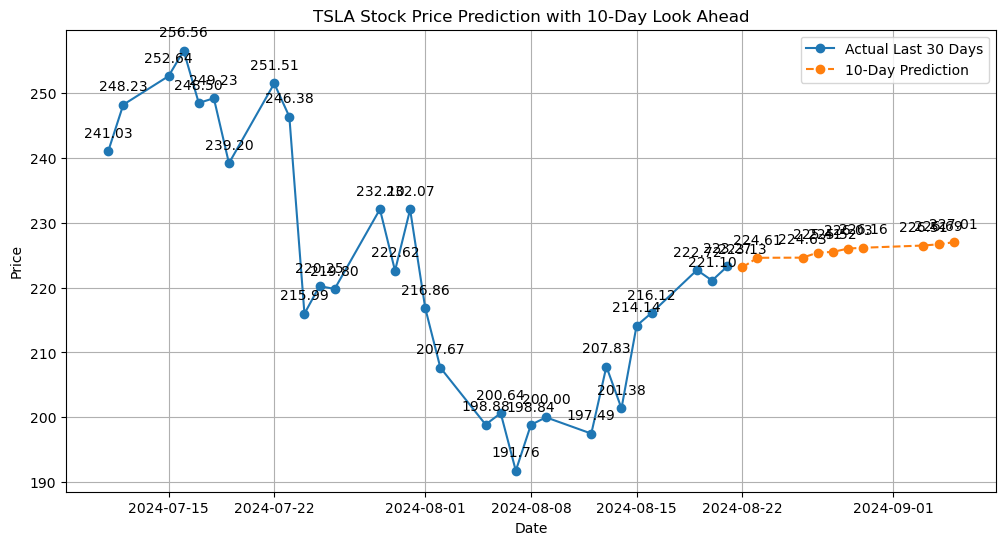

,Date,Predicted
0,2024-08-22 00:00:00+00:00,223.126435
1,2024-08-23 00:00:00+00:00,224.613217
2,2024-08-26 00:00:00+00:00,224.633293
3,2024-08-27 00:00:00+00:00,225.414599
4,2024-08-28 00:00:00+00:00,225.516866
5,2024-08-29 00:00:00+00:00,226.033966
6,2024-08-30 00:00:00+00:00,226.163561
7,2024-09-03 00:00:00+00:00,226.506158
8,2024-09-04 00:00:00+00:00,226.691625
9,2024-09-05 00:00:00+00:00,227.011576


In [73]:
# Function to predict n days ahead
def predict_n_days_ahead(model, data, window, scaler, n_days):
    model.eval()
    with torch.no_grad():
        predictions = []
        input_seq = torch.tensor(data[-window:], dtype=torch.float32).unsqueeze(0)
        for _ in range(n_days):
            output = model(input_seq)
            predictions.append(output.item())
            output = output.view(1, 1, -1)
            input_seq = torch.cat((input_seq[:, 1:, :], output), dim=1)

    return scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

# Function to plot actual and predicted values for n days
def plot_actual_and_predicted(df, future_predictions, n_days):
    last_n_days_actual = df['Close'].values[-((3*n_days)):]

    # Get the trading calendar for the stock market
    nyse = mcal.get_calendar('NYSE')
    next_trading_days = nyse.valid_days(start_date=df.index[-1], end_date=pd.Timestamp.today() + pd.DateOffset(days=2*n_days))

    date_range_future = next_trading_days[1:n_days+1]
    future_df = pd.DataFrame({'Date': date_range_future, 'Predicted': future_predictions})

    # Plotting the actual and predicted values
    plt.figure(figsize=(12, 6))
    plt.plot(df.index[-(3*n_days):], last_n_days_actual, label=f'Actual Last {(3*n_days)} Days', marker='o')
    plt.plot(date_range_future, future_predictions, label=f'{n_days}-Day Prediction', linestyle='dashed', marker='o')

    # Annotate actual values
    for i, txt in enumerate(last_n_days_actual):
        plt.annotate(f'{txt:.2f}', (df.index[-(3*n_days) + i], last_n_days_actual[i]), textcoords="offset points", xytext=(0,10), ha='center')

    # Annotate predicted values
    for i, txt in enumerate(future_predictions):
        plt.annotate(f'{txt:.2f}', (date_range_future[i], future_predictions[i]), textcoords="offset points", xytext=(0,10), ha='center')

    plt.title(f'TSLA Stock Price Prediction with {n_days}-Day Look Ahead')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    return future_df

# Real testing
n_days = 10  # Change this to any number of days you want to predict
future_predictions = predict_n_days_ahead(model, data_normalized, hyperparameters['window'], scaler, n_days)

future_df = plot_actual_and_predicted(df, future_predictions, n_days)
future_df